In [7]:
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats

from scipy.interpolate import griddata

In [152]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# az.style.use('arviz-white')
# %load_ext watermark 
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['legend.fontsize']=12
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['figure.titlesize']=15

#### 4.1. Why normal distributions are normal
##### 4.1.1. Normal by addition

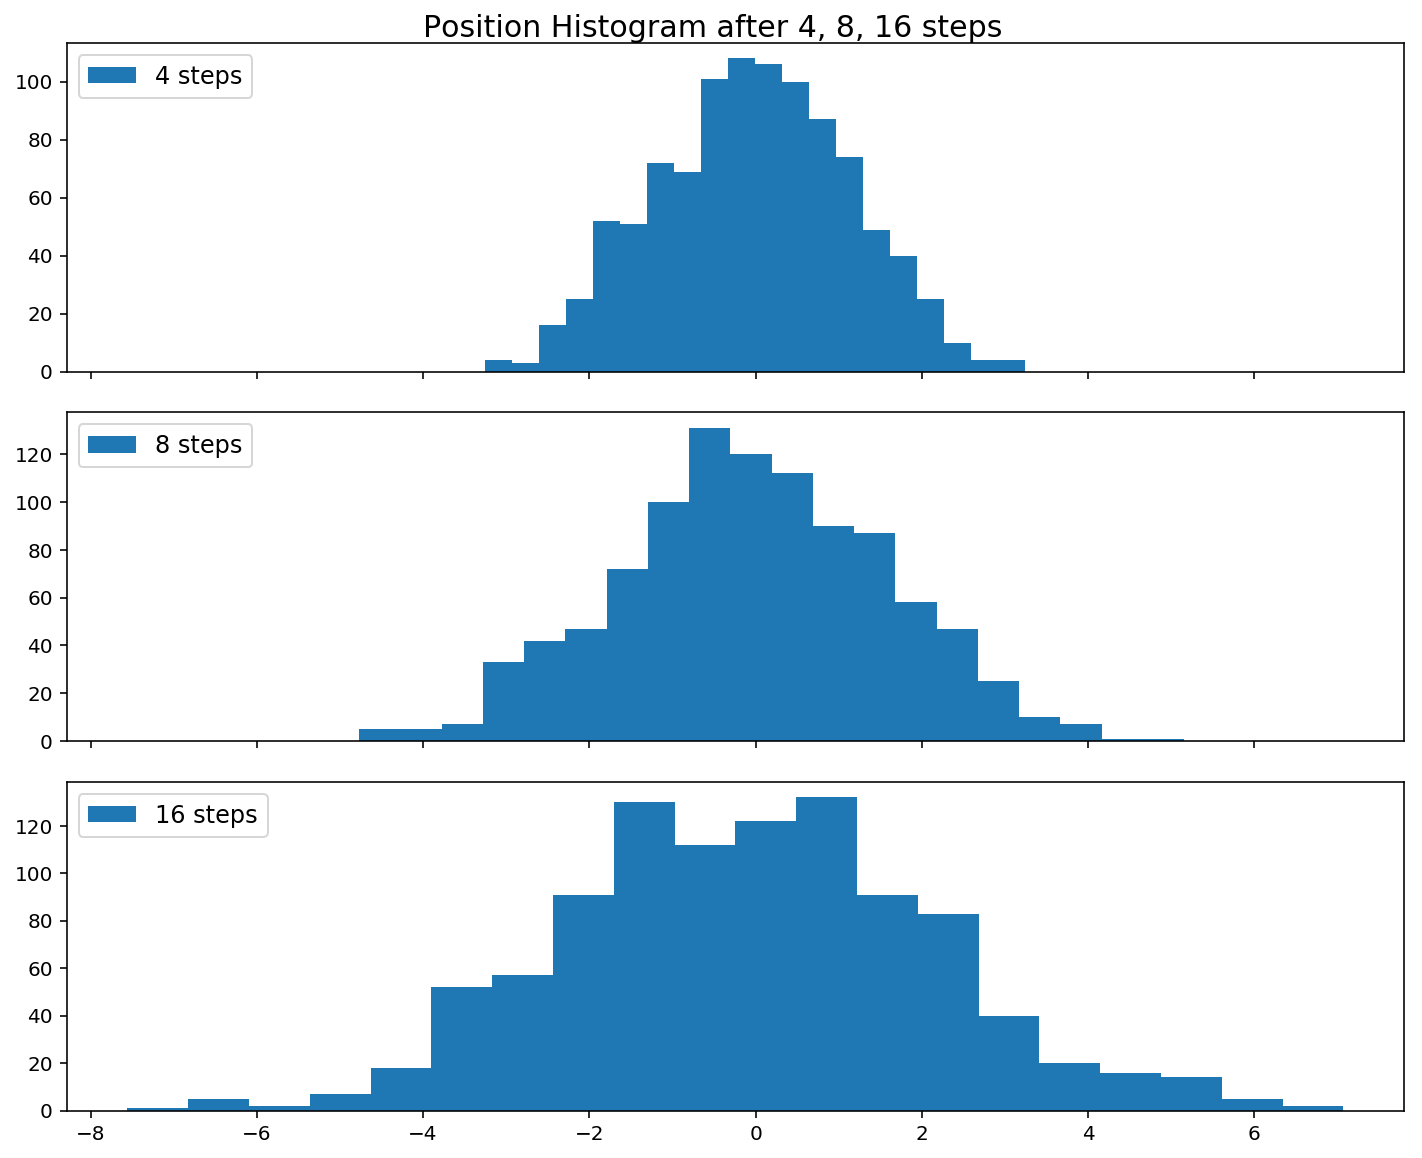

In [153]:
# code 4.1
np.random.seed(157)
_, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False,figsize=(10,8))
for idx, n in enumerate([4, 8, 16]):
    pos = np.random.uniform(low=-1,high=1, size=(1000, n)).sum(axis=1)
    axes[idx].hist(pos, label=f'{n} steps', bins=20)
    axes[idx].legend(loc=2, fontsize=12)
pass
plt.suptitle('Position Histogram after 4, 8, 16 steps', y=1)
plt.tight_layout()

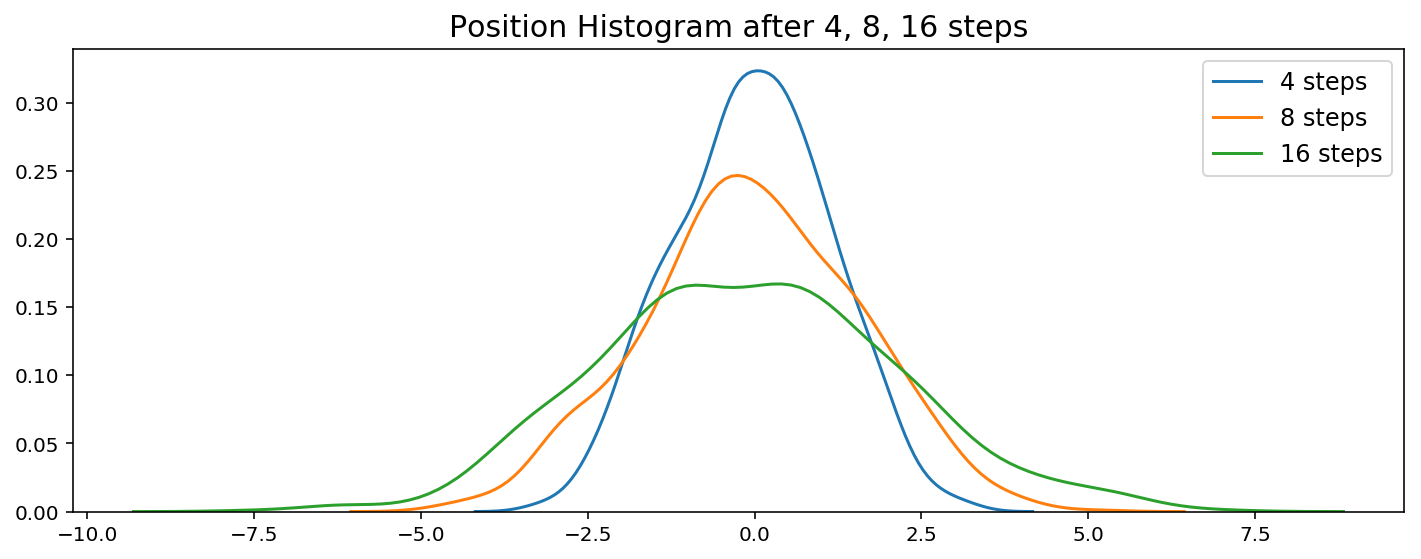

In [154]:
# code 4.1
np.random.seed(157)
_, _ = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
for idx, n in enumerate([4, 8, 16]):
    pos = np.random.uniform(low=-1,high=1, size=(1000, n)).sum(axis=1)
    sns.kdeplot(pos, label=f'{n} steps')
plt.title('Position Histogram after 4, 8, 16 steps', fontsize=15)
plt.tight_layout()

##### 4.1.2 Normal by multiplication

In [155]:
# code 4.2, 4.3 and 4.4
def gen_and_plot_mul_vars(low=1, high=1.1, n_vars=12, n_reps=10000):
    growth = np.random.uniform(low, high, size=(n_reps, n_vars)).prod(axis=1)
    sns.kdeplot(growth)
    plt.title(f"Density of multiplied {n_vars} random uniform variables\nlow={low}; high={high}")

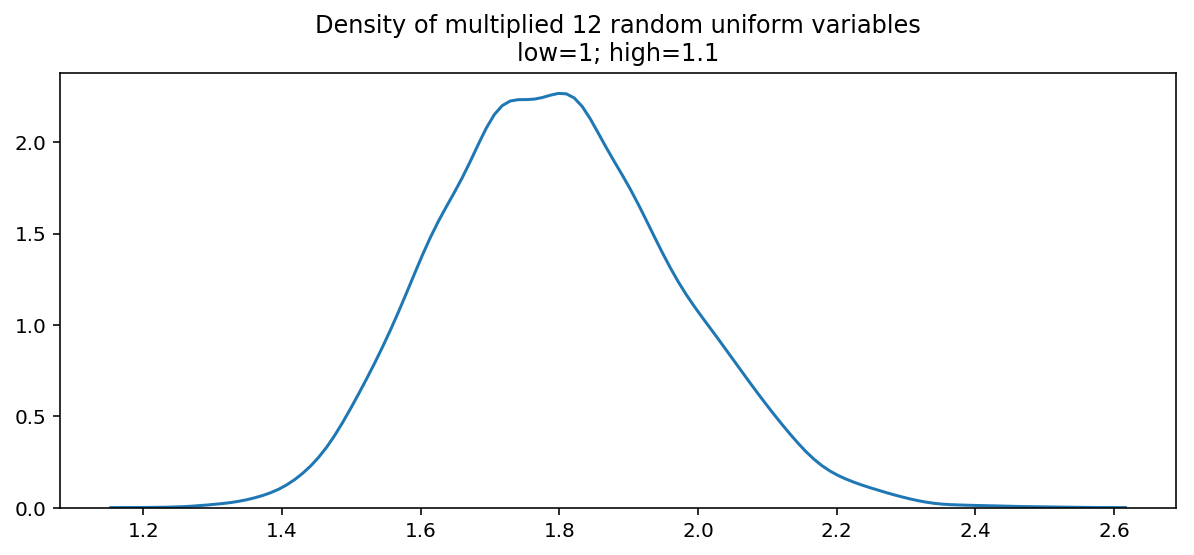

In [156]:
gen_and_plot_mul_vars()

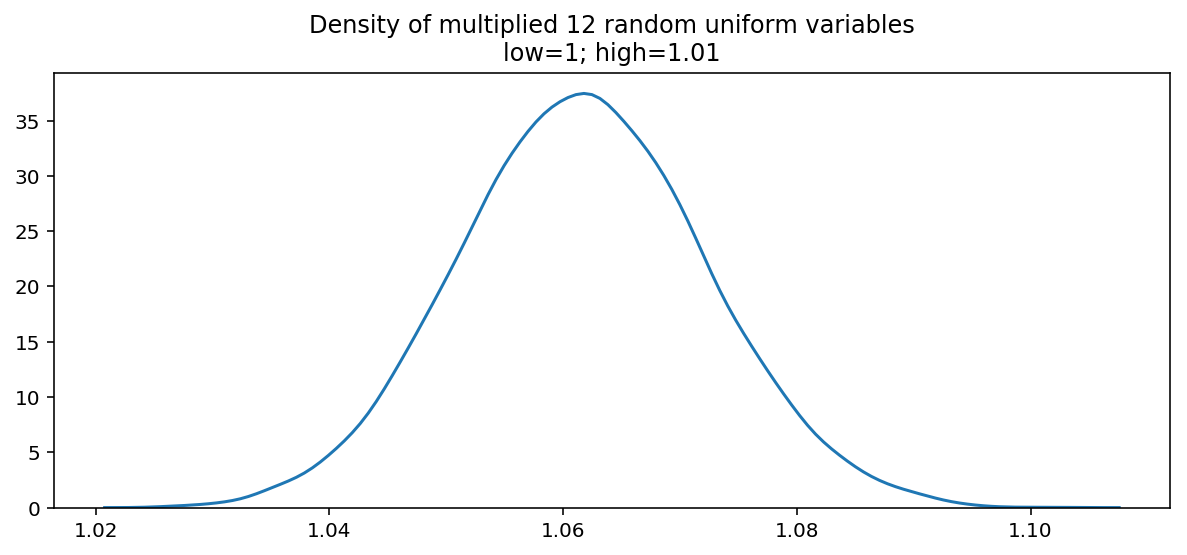

In [157]:
gen_and_plot_mul_vars(high=1.01)

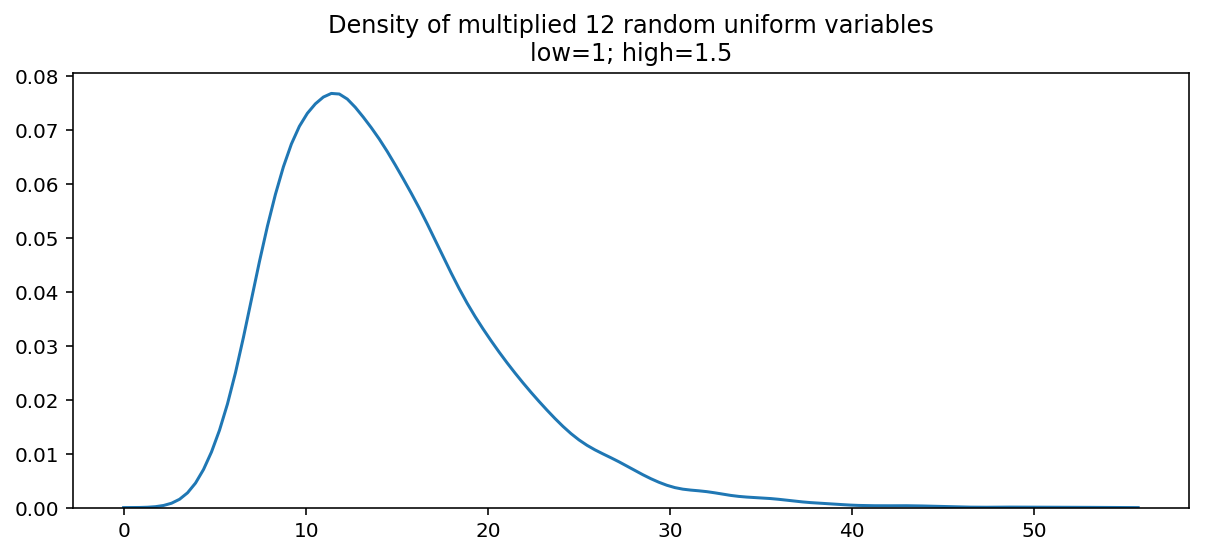

In [158]:
gen_and_plot_mul_vars(high=1.5)

##### 4.1.3. Normal by log-multiplication

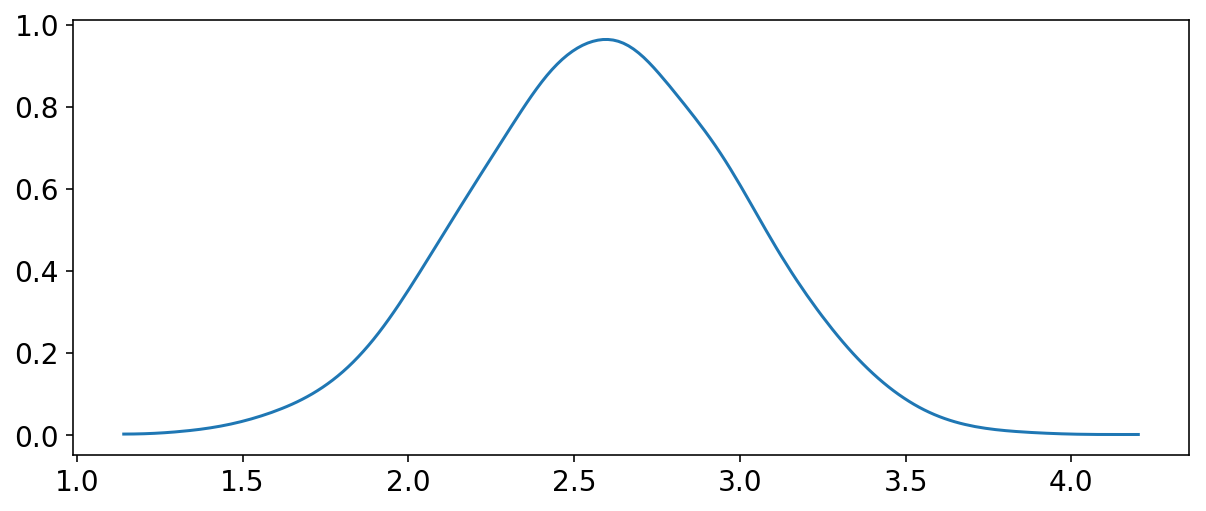

In [159]:
# code 4.5
log_big = np.log(np.random.uniform(low=1, high=1.5, size=(10000, 12)).prod(axis=1))
az.plot_kde(log_big)
pass

#### 4.2. A language for describing models
##### 4.2.1. Re-describing the globe tossing model

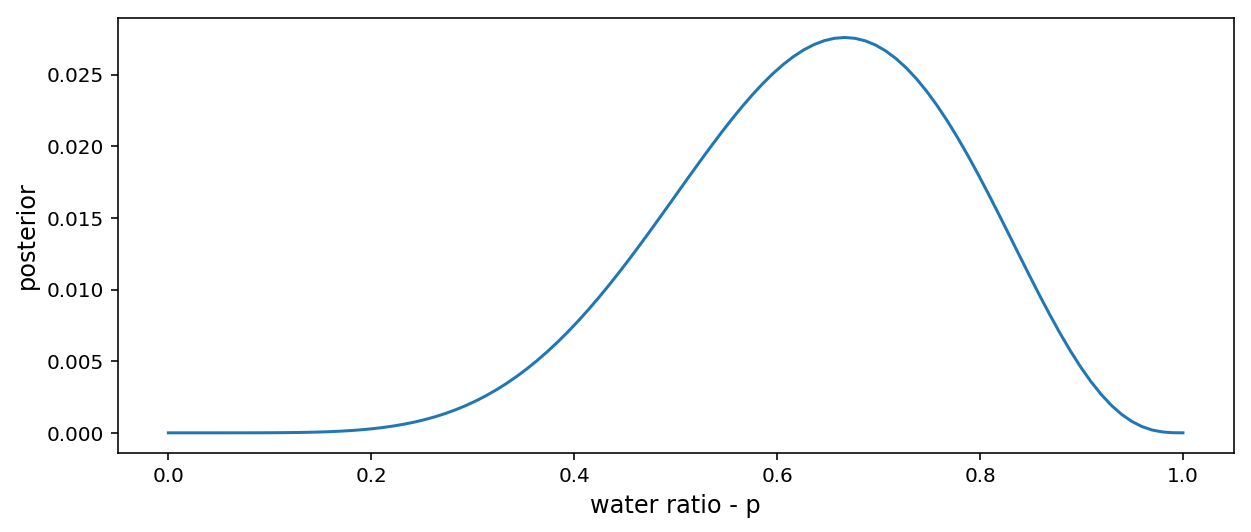

In [161]:
# code 4.6
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(x=p_grid)
posterior = posterior / posterior.sum()
plt.plot(p_grid, posterior)
plt.xlabel('water ratio - p')
plt.ylabel('posterior')
pass

#### 4.3. Gaussian model of height
##### 4.3.1. The data

In [164]:
# 4.7 & 4.8
d = pd.read_csv("~/Learning_DS/pymc3_resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

In [174]:
# 4.9
az.summary(d.to_dict('list'), kind="stats")

mean      sd  hpd_5.5%  hpd_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

In [175]:
# 4.10
d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [178]:
# 4.11
d2 = d.copy()[d.age>=18]

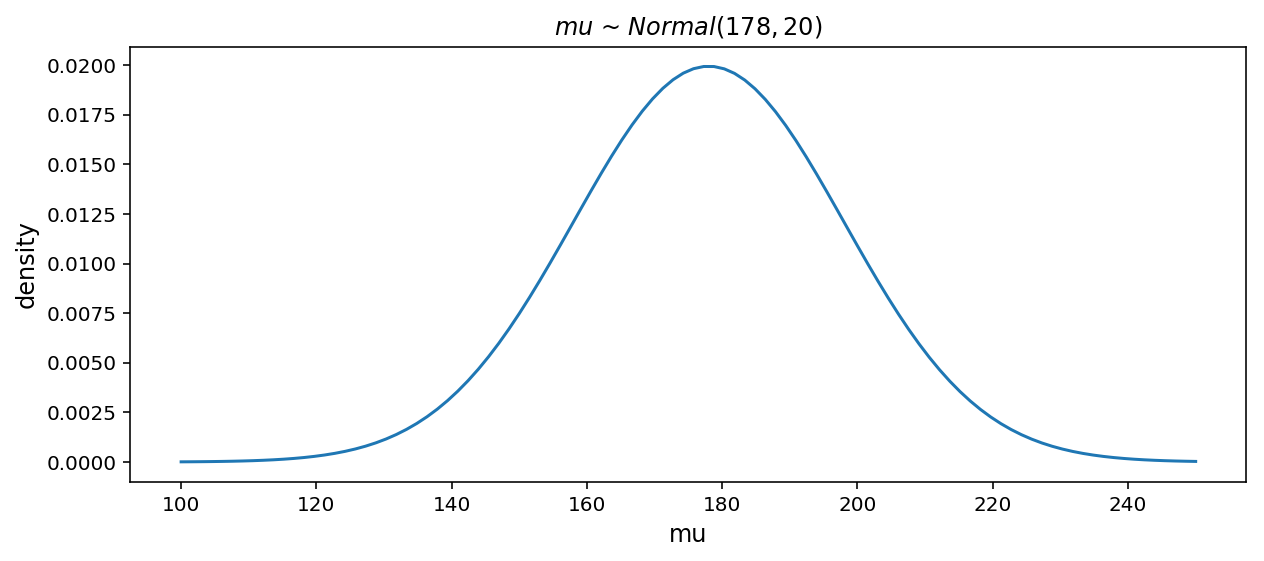

In [191]:
# 4.12
mu_grid = np.linspace(100, 250, 100)
plt.plot(mu_grid, stats.norm.pdf(x=mu_grid, loc=178, scale=20))
plt.xlabel("mu")
plt.ylabel("density")
plt.title('$mu$ ~ $Normal(178, 20)$')
pass

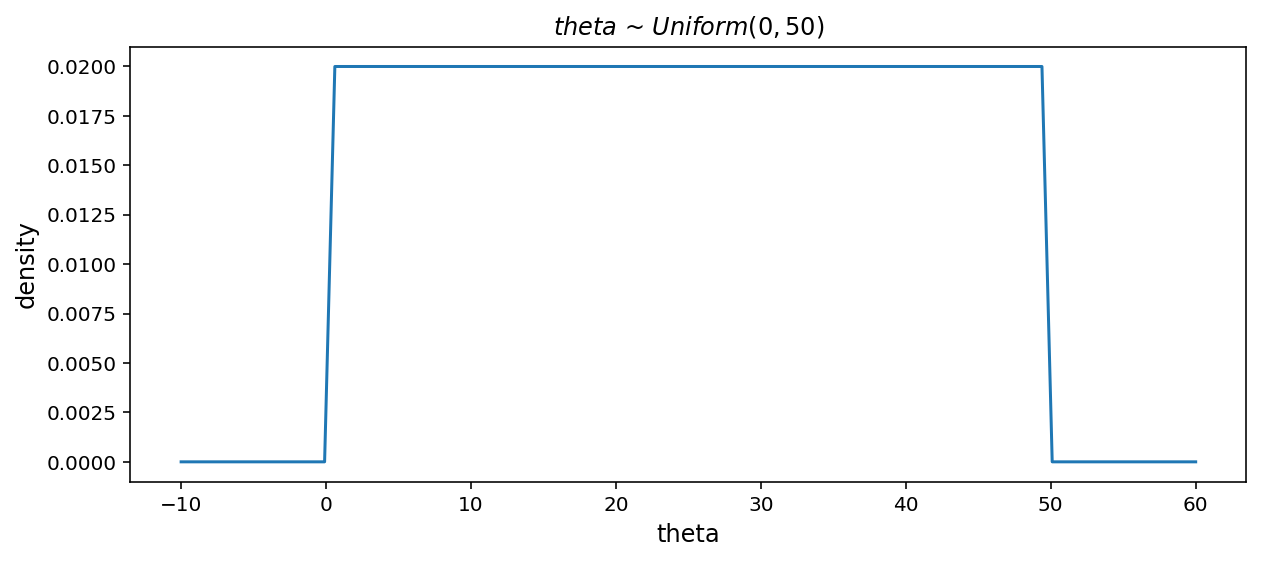

In [196]:
# 4.13
theta_grid = np.linspace(start=-10, stop=60, num=100)
plt.plot(theta_grid, stats.uniform.pdf(x=theta_grid, loc=0, scale=50))
plt.xlabel("theta")
plt.ylabel("density")
plt.title('$theta$ ~ $Uniform(0, 50)$')
pass

##### Prior Predictive Simulation

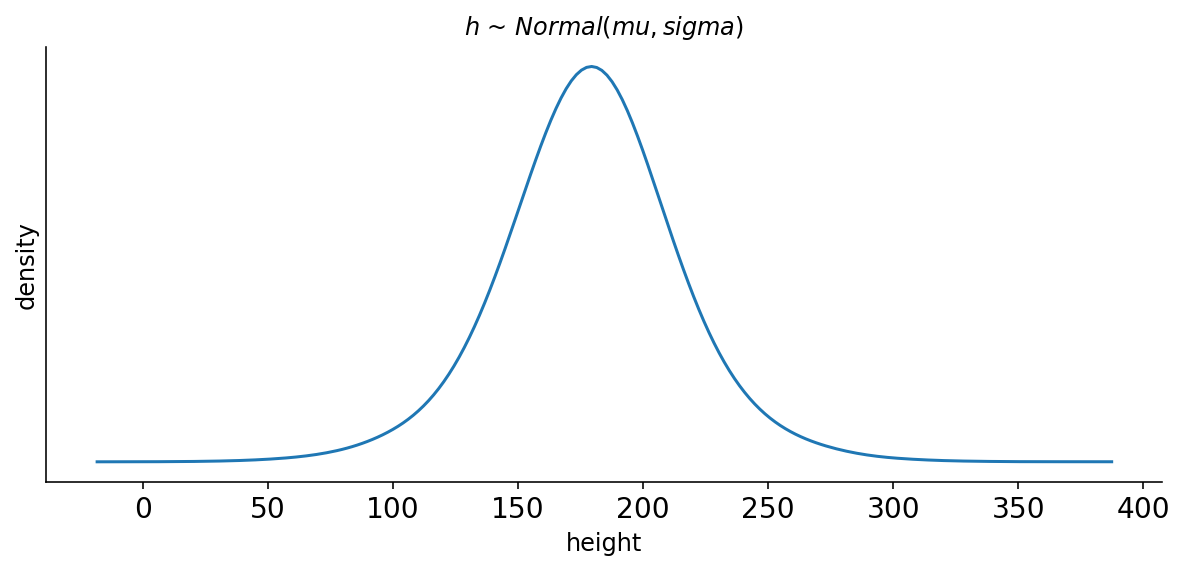

In [204]:
# 4.14
n = int(10e4)
sample_mu = stats.norm(loc=178, scale=20).rvs(size=n)
sample_sigma = stats.uniform(loc=0, scale=50).rvs(size=n)
prior_h = stats.norm(loc=sample_mu, scale=sample_sigma).rvs(size=n)
az.plot_kde(prior_h)
plt.xlabel('height')
plt.ylabel("density")
plt.yticks([])
sns.despine()
plt.title("$h$ ~ $Normal(mu, sigma)$")
pass

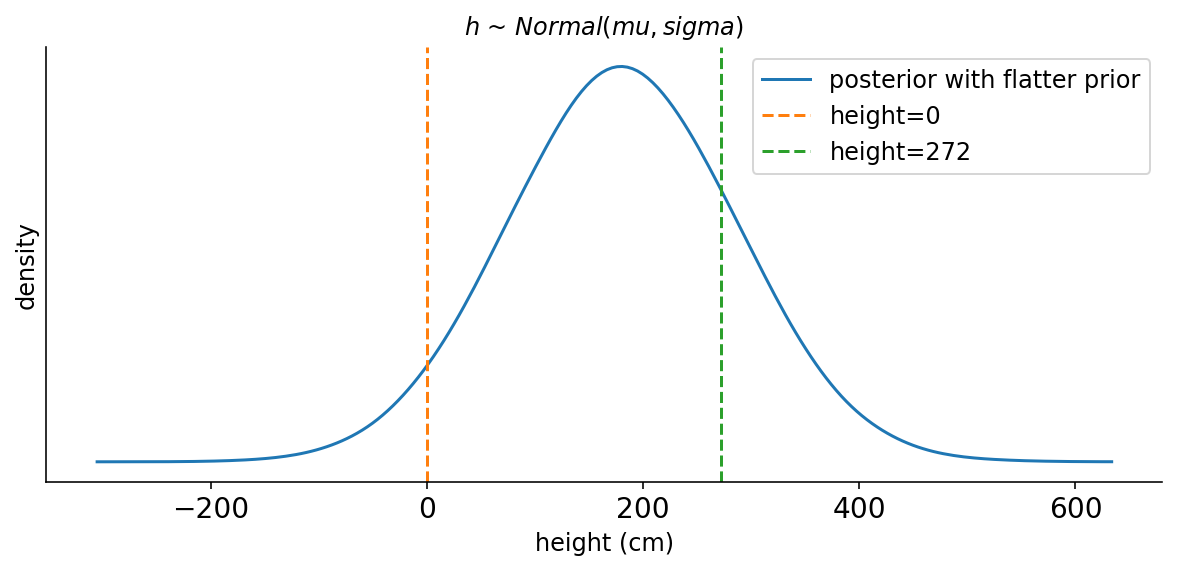

In [234]:
# 4.15
sample_mu = stats.norm(loc=178, scale=100).rvs(size=n)
prior_h = stats.norm(loc=sample_mu, scale=sample_sigma).rvs()
az.plot_kde(prior_h, label='posterior with flatter prior')
plt.axvline(x=0, linestyle='--', color='C1', label='height=0')
plt.axvline(x=272, linestyle='--', color='C2', label='height=272')
plt.xlabel('height (cm)')
plt.ylabel("density")
plt.legend(loc=0)
plt.yticks([])
sns.despine()
plt.title("$h$ ~ $Normal(mu, sigma)$")
pass

##### 4.3.3. Grid approximation for the posterior distribution

In [310]:
# 4.16
para_grid = np.mgrid[150:160:(10/100), 7:9:(2/100)].reshape(2, -1).T
# after log transform, multiplying all observations' LL becomes a summation
likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=para_grid[idx,0], scale=para_grid[idx,1]))
    for idx in range(len(para_grid))
]

post_prod = (
    likelihood + 
    stats.norm.logpdf(para_grid[:,0], loc=178, scale=20) +
    stats.uniform.logpdf(para_grid[:,1], loc=0, scale=50)
)

post_prob = np.exp(post_prod - np.max(post_prod))

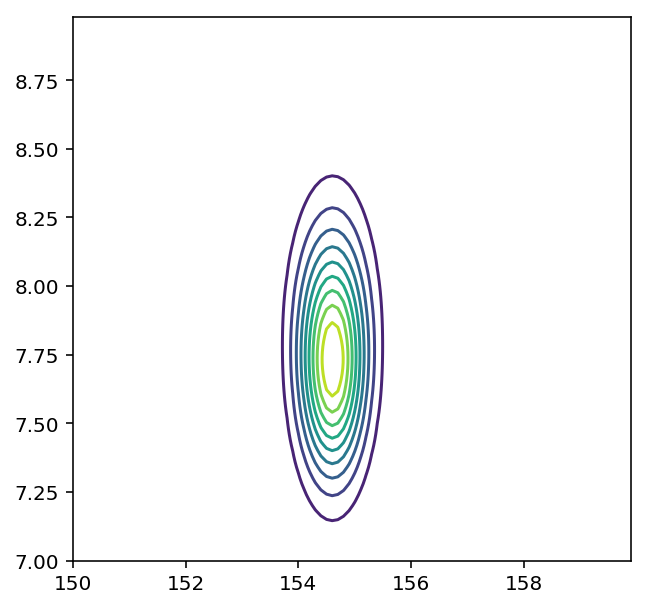

In [311]:
# 4.17
_ = plt.figure(figsize=(5, 5))
plt.contour(para_grid[:,0].reshape(100,100), 
            para_grid[:,1].reshape(100,100), 
            post_prob.reshape(100,100), 
            levels=10)

In [309]:
# 4.18
# image plot on posterior probs -> skip

##### 4.3.4. Sampling from the posterior

In [328]:
# 4.19
n_samples = int(1e4)
sample_indices = np.random.choice(
    np.arange(len(para_grid)), size=n_samples, replace=True, p=post_prob/sum(post_prob))
sample_mu = para_grid[sample_indices, 0]
sample_sigma = para_grid[sample_indices, 1]

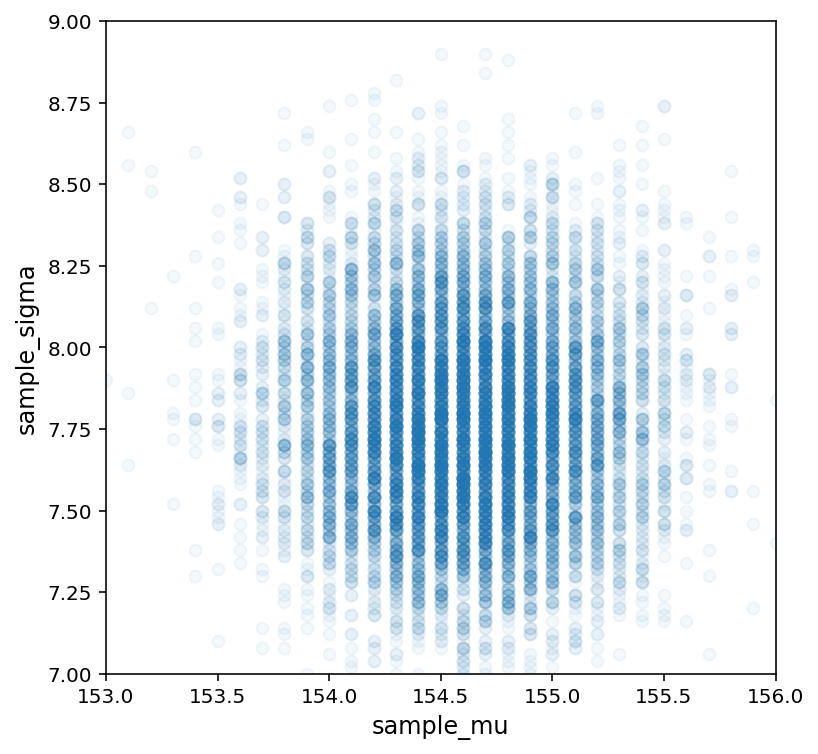

In [338]:
# 4.20
_ = plt.figure(figsize=(6,6))
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.xlim(left=153, right=156)
plt.ylim(bottom=7, top=9)
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma")
pass

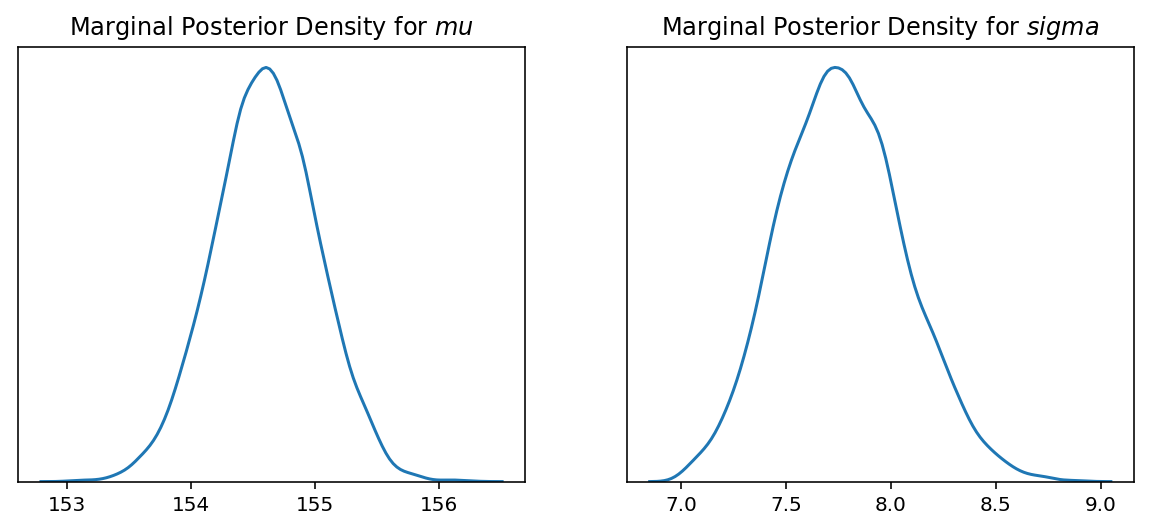

In [358]:
# 4.21
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.kdeplot(sample_mu, ax=ax1)
ax1.set_title('Marginal Posterior Density for $mu$')
ax1.set_yticks([])
sns.kdeplot(sample_sigma, ax=ax2)
ax2.set_title('Marginal Posterior Density for $sigma$')
ax2.set_yticks([])
pass

In [362]:
# 4.22
az.hpd(sample_mu), az.hpd(sample_sigma)

(array([153.9, 155.2]), array([7.32, 8.26]))

Posterior of standard deviation may not be Gaussian in shape, esp when sample size is small. For demostration, use only 20 observations and repeat the grid approximation steps above.

In [364]:
# 4.23
d3 = d2.sample(n=20, replace=False)

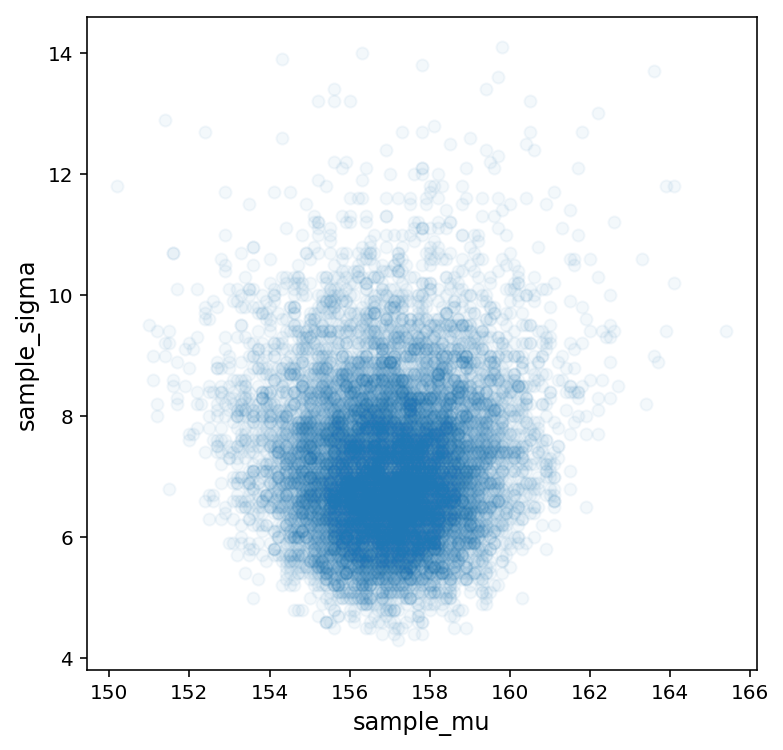

In [366]:
# 4.24
## grid approximation
para_grid2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T
# use d3 instead d2
likelihood2 = [
    sum(stats.norm.logpdf(d3.height, loc=para_grid2[idx,0], scale=para_grid2[idx,1]))
    for idx in range(len(para_grid2))
]

post_prod2 = (
    likelihood2 + 
    stats.norm.logpdf(para_grid2[:,0], loc=178, scale=20) +
    stats.uniform.logpdf(para_grid2[:,1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - np.max(post_prod2))

## sample from posterior
sample_indices2 = np.random.choice(
    np.arange(len(para_grid2)), size=n_samples, replace=True, p=post_prob2/sum(post_prob2))
sample_mu2 = para_grid2[sample_indices2, 0]
sample_sigma2 = para_grid2[sample_indices2, 1]

## plot
_ = plt.figure(figsize=(6,6))
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
# plt.xlim(left=153, right=156)
# plt.ylim(bottom=7, top=9)
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma")
pass

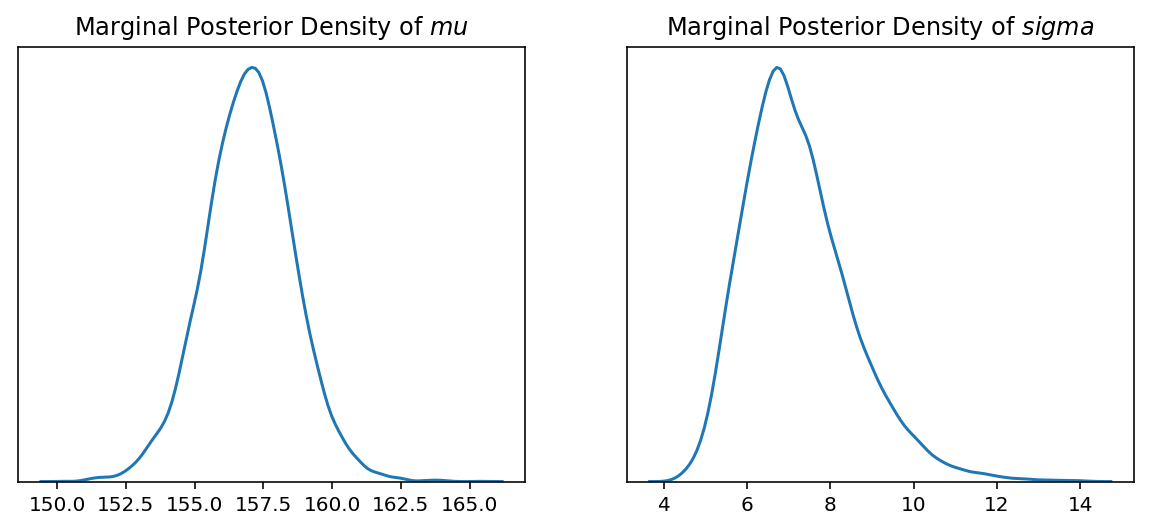

In [367]:
# code 4.25
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.kdeplot(sample_mu2, ax=ax1)
ax1.set_title('Marginal Posterior Density of $mu$')
ax1.set_yticks([])
sns.kdeplot(sample_sigma2, ax=ax2)
ax2.set_title('Marginal Posterior Density of $sigma$')
ax2.set_yticks([])
pass

With fewer observations, uncertainty of both parameter estimates increase. The posterior of $mu$ still remains gausian (gaussian prior + gaussian likelihood), while $sigma$'s now has a longer right-hand tail.

In [377]:
# nr observations
len(d2), len(d3)

(352, 20)

In [375]:
az.hpd(sample_sigma), az.hpd(sample_sigma2)

(array([7.32, 8.26]), array([5.3, 9.1]))

In [379]:
az.hpd(sample_mu), az.hpd(sample_mu2)

(array([153.9, 155.2]), array([154.3, 159.4]))

##### 4.3.5. Finding the posterior distributions with pymc

In [382]:
# 4.26
d = pd.read_csv("~/Learning_DS/pymc3_resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d2 = d.copy()[d.age>=18]

In [388]:
# 4.27
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    h = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

In [390]:
# 4.28
with m4_1:
    trace_4_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4046.44draws/s]


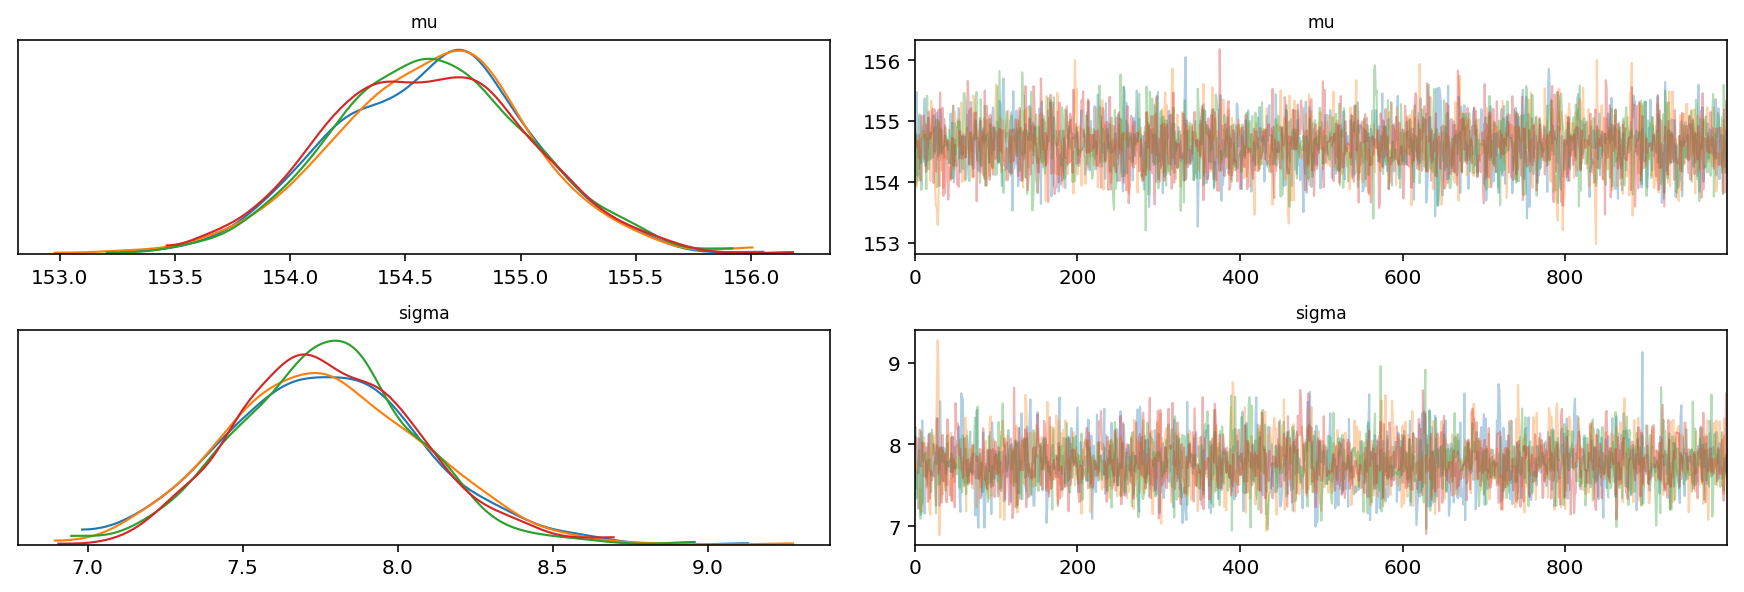

In [392]:
az.plot_trace(trace_4_1)
pass

In [393]:
# 4.29
az.summary(trace_4_1, round_to=2, kind='stats')

mean    sd  hpd_5.5%  hpd_94.5%
mu     154.61  0.42    153.88     155.22
sigma    7.77  0.30      7.29       8.24

In [399]:
# 4.30
# give inital values for sampler to explore the parameter space
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3855.12draws/s]


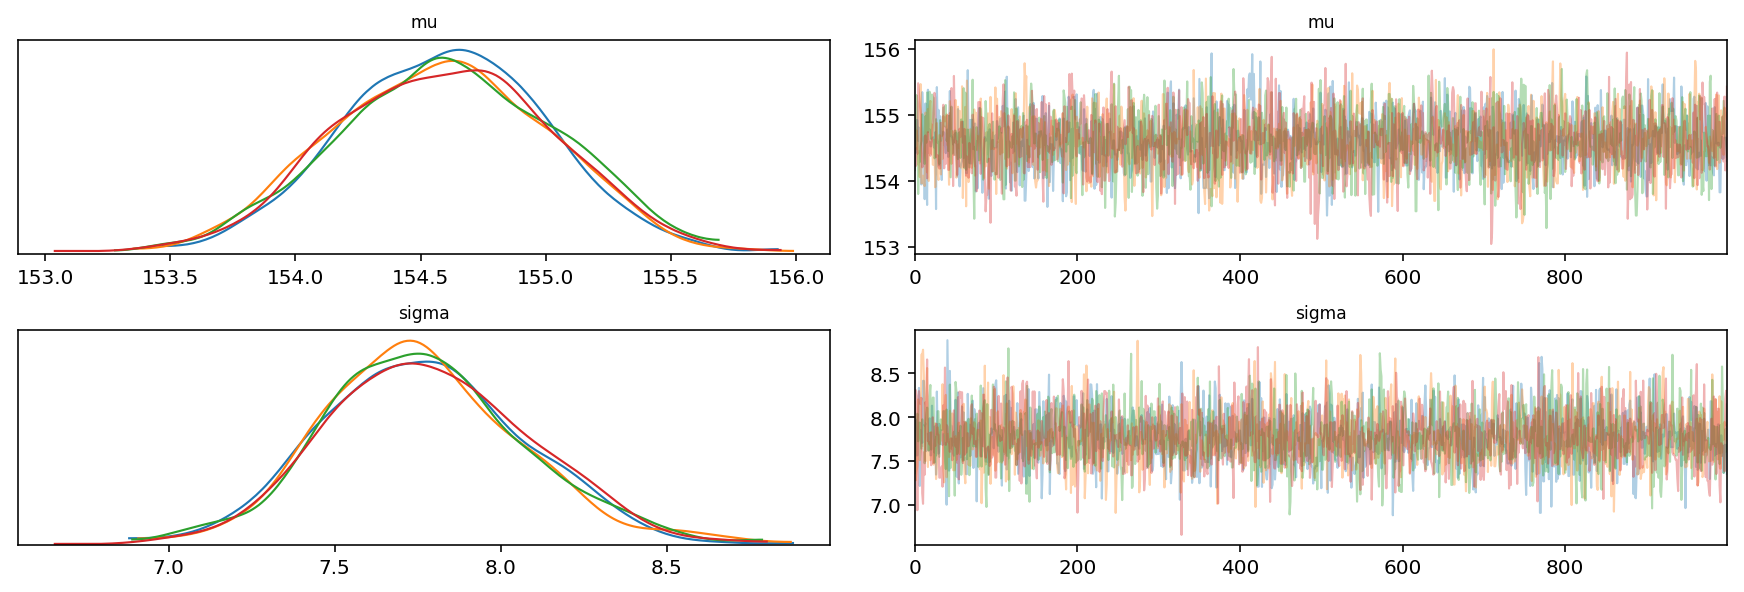

In [401]:
az.plot_trace(trace_4_1)
pass

In [403]:
# 4.31
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sigma=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4652.46draws/s]


mean    sd  hpd_5.5%  hpd_94.5%
mu     177.86  0.10     177.7     178.03
sigma   24.61  0.95      23.1      26.17

##### 4.3.6. Sampling from pymc model

In [407]:
# 4.32
# covariance matrix of mu and sigma
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.183073  0.006952
sigma  0.006952  0.091536

In [414]:
# 4.33
# get variance only
trace_df.var()

mu       0.183073
sigma    0.091536
dtype: float64

In [411]:
# get correlation matrix instead of covariance
trace_df.corr()

mu     sigma
mu     1.000000  0.053703
sigma  0.053703  1.000000

In [431]:
# 4.34
# sample from posterior, which is a multi-dimensional gaussian distrbution
trace_df.head()

mu     sigma
0  154.877040  7.528930
1  154.417083  7.973050
2  154.914739  7.565304
3  154.914739  7.565304
4  154.601847  7.874449

In [434]:
trace_4_1["sigma"][:10]

array([7.52893047, 7.9730502 , 7.56530419, 7.56530419, 7.87444917,
       8.33514396, 7.21641212, 7.85203914, 7.79625204, 7.70924716])

In [435]:
# 4.35
az.summary(trace_4_1, round_to=2, kind='stats')

mean    sd  hpd_5.5%  hpd_94.5%
mu     154.60  0.43    153.98     155.34
sigma    7.77  0.30      7.31       8.26

In [436]:
# 4.36
stats.multivariate_normal(mean=trace_df.mean(), cov=trace_df.cov()).rvs(size=10)

array([[153.70821954,   7.56591533],
       [154.65483784,   7.84403145],
       [153.94164896,   8.04972443],
       [154.45792783,   7.95844088],
       [154.68042611,   8.16243703],
       [154.3273027 ,   7.82705188],
       [155.34985762,   8.40383111],
       [154.88052217,   7.71975805],
       [154.97326234,   8.01263442],
       [153.96710501,   7.6864798 ]])

### 4.4. Linear Prediction

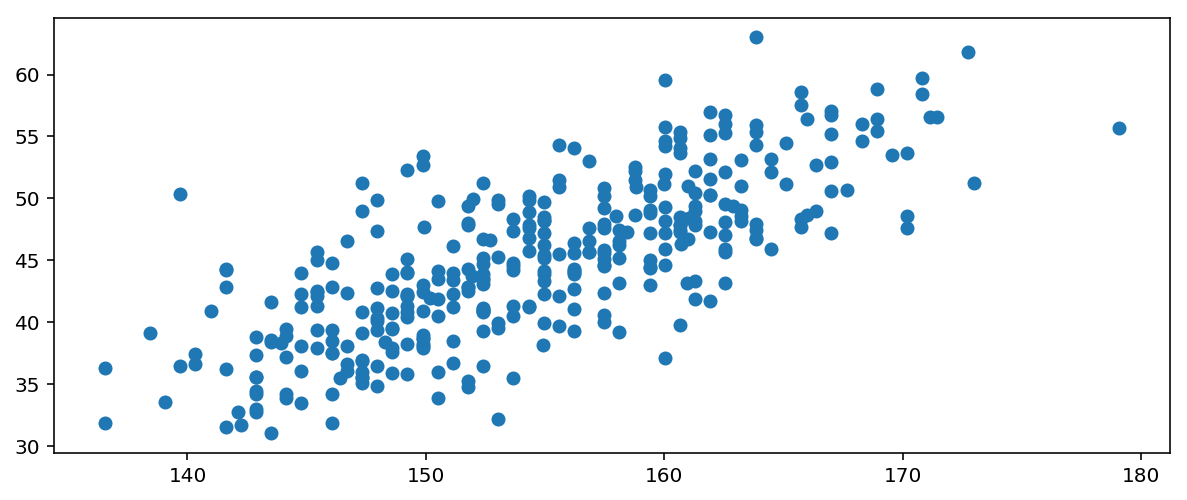

In [441]:
# 4.37
plt.plot(d2.height, d2.weight, 'o')

In [442]:
# 4.38
np.random.seed(135)
N = 100
a = stats.norm.rvs(size=N, loc=178, scale=20)
b = stats.norm.rvs(size=N, loc=0, scale=10)

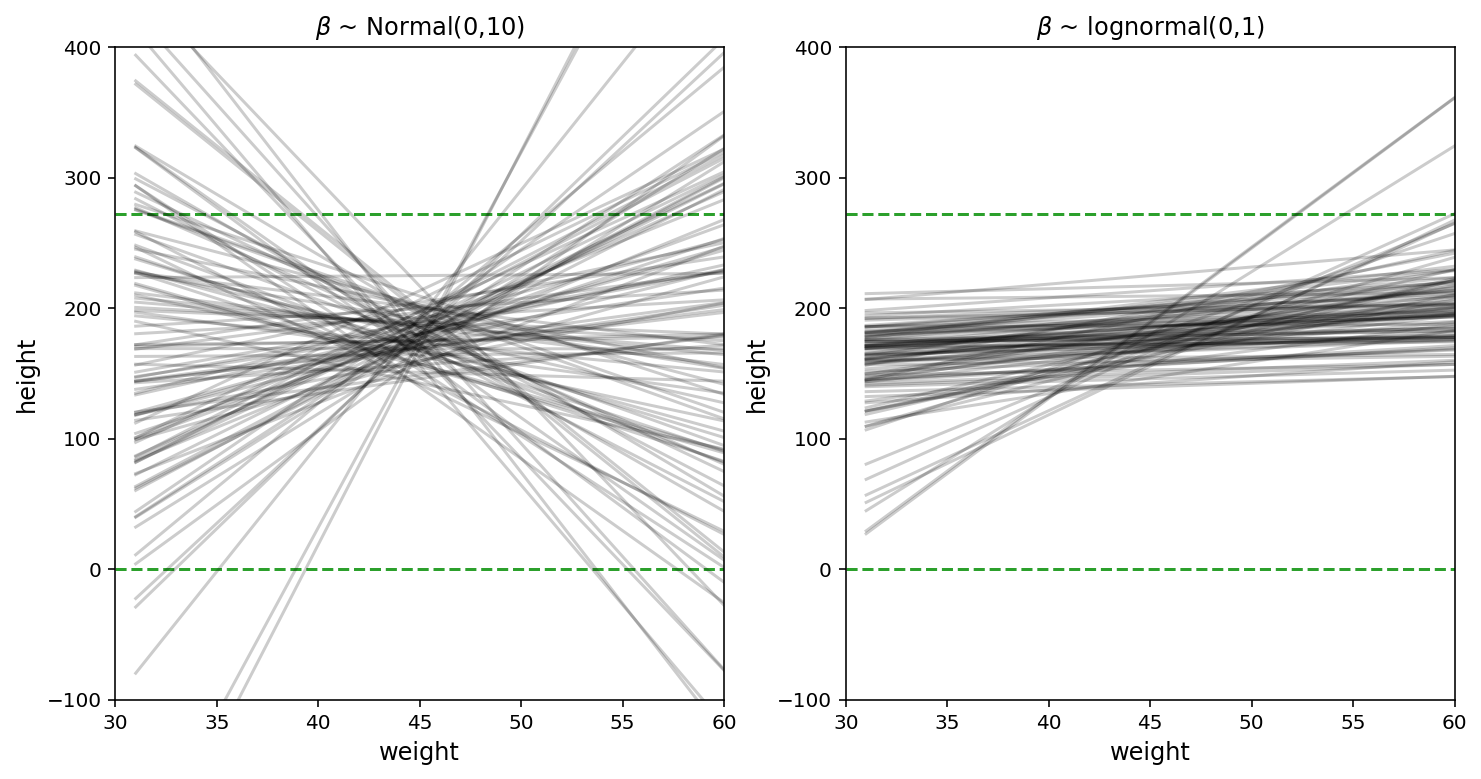

In [501]:
# 4.39, 4.40 & 4.41
xbar = d2.weight.mean()
x_range = np.arange(int(d2.weight.min()), int(d2.weight.max()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.axhline(y=0, color='C2', linestyle='--')
ax1.axhline(y=272, color='C2', linestyle='--')
ax1.set_title(r'$\beta$ ~ Normal(0,10)')
ax1.set_xlim(30, 60)
ax1.set_ylim(-100, 400)
ax1.set_xlabel("weight")
ax1.set_ylabel("height")
for i in range(N):
    ax1.plot(x_range, a[i]+b[i]*(x_range - xbar), color="k", alpha=0.2)

# with beta ~ lognormal(0,1)
b2 = stats.lognorm.rvs(size=N, s=1)
ax2.axhline(y=0, color='C2', linestyle='--')
ax2.axhline(y=272, color='C2', linestyle='--')
ax2.set_title(r'$\beta$ ~ lognormal(0,1)')
ax2.set_xlim(30, 60)
ax2.set_ylim(-100, 400)
ax2.set_xlabel("weight")
ax2.set_ylabel("height")
for i in range(N):
    ax2.plot(x_range, a[i]+b2[i]*(x_range - xbar), color="k", alpha=0.2)

pass

##### 4.4.2. Finding the posterior distribution

In [508]:
# 4.42
# use beta as lognormal
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3756.78draws/s]


In [514]:
# 4.43 
# use beta as normal then in contructing mu, set exp(beta)
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    log_b = pm.Normal("log_b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = a + np.exp(log_b) * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, log_b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3797.61draws/s]


##### 4.4.3. Interpreting the posterior distribution
###### 4.4.3.1. Table of marginal distributions

In [520]:
# 4.44
az.summary(trace_4_3, round_to=2, kind="stats")

mean    sd  hpd_5.5%  hpd_94.5%
a      154.6  0.27    154.18     155.06
b        0.9  0.04      0.84       0.98
sigma    5.1  0.20      4.76       5.38

In [519]:
# 4.45
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df.cov()

a         b     sigma
a      0.074694 -0.000006 -0.000104
b     -0.000006  0.001850 -0.000072
sigma -0.000104 -0.000072  0.038948

###### 4.4.3.2. Plotting posterior inference against the data

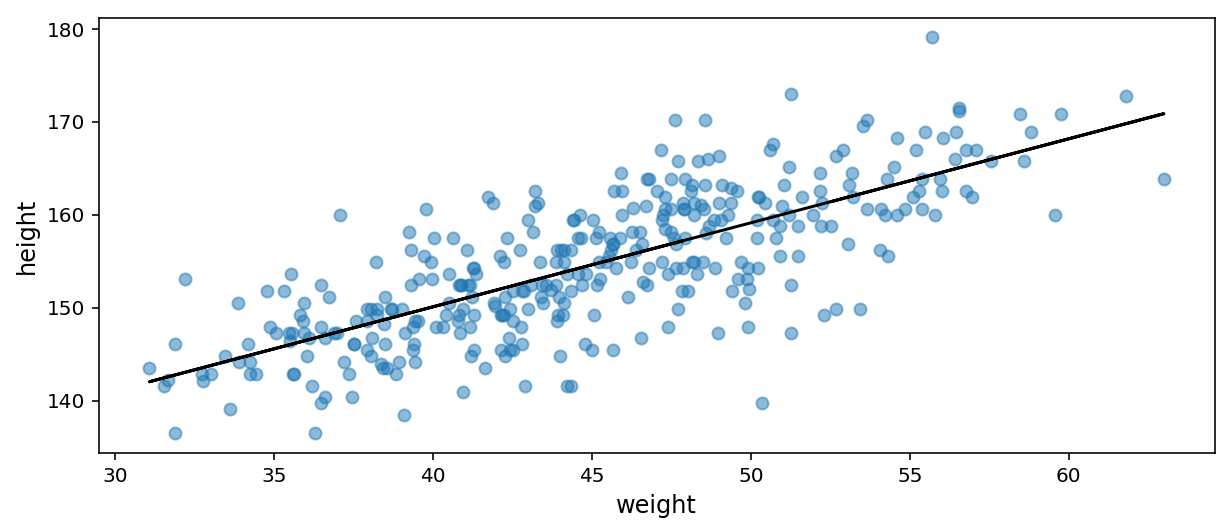

In [540]:
# 4.46
# impose posterior means over the data
mean_a = trace_4_3['a'].mean()
mean_b = trace_4_3['b'].mean()

plt.plot(d2.weight, d2.height, 'o', alpha=0.5)
plt.plot(d2.weight, mean_a + mean_b * (d2.weight-xbar), "k-", linewidth=1.5)
plt.xlabel('weight')
plt.ylabel('height')
pass

###### 4.4.3.3. Adding uncertainty around the mean

In [541]:
# 4.47
trace_4_3_df.head()

a         b     sigma
0  154.615021  0.880584  5.290478
1  154.384549  0.944118  4.904986
2  154.617224  0.935767  4.887959
3  154.589130  0.864630  5.157328
4  155.120697  0.906091  4.932934

In [552]:
from collections import namedtuple
NTrace = namedtuple("NTrace", ['dN', 'xbar', 'trace'])

In [579]:
# 4.48
N = [10, 50, 150, 352]
samples_N = []

for size in N:
    dN = d2.sample(n=size)
    xbar = dN.weight.mean()
    
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sigma=20)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", lower=0, upper=50)
        mu = pm.Deterministic("mu", a + b * (dN.weight - xbar))
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height)
        trace_N = pm.sample(1000, tune=1000)
    
    samples_N.append(NTrace(dN, xbar, trace_N))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3343.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3731.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3617.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3749.86draws/s]


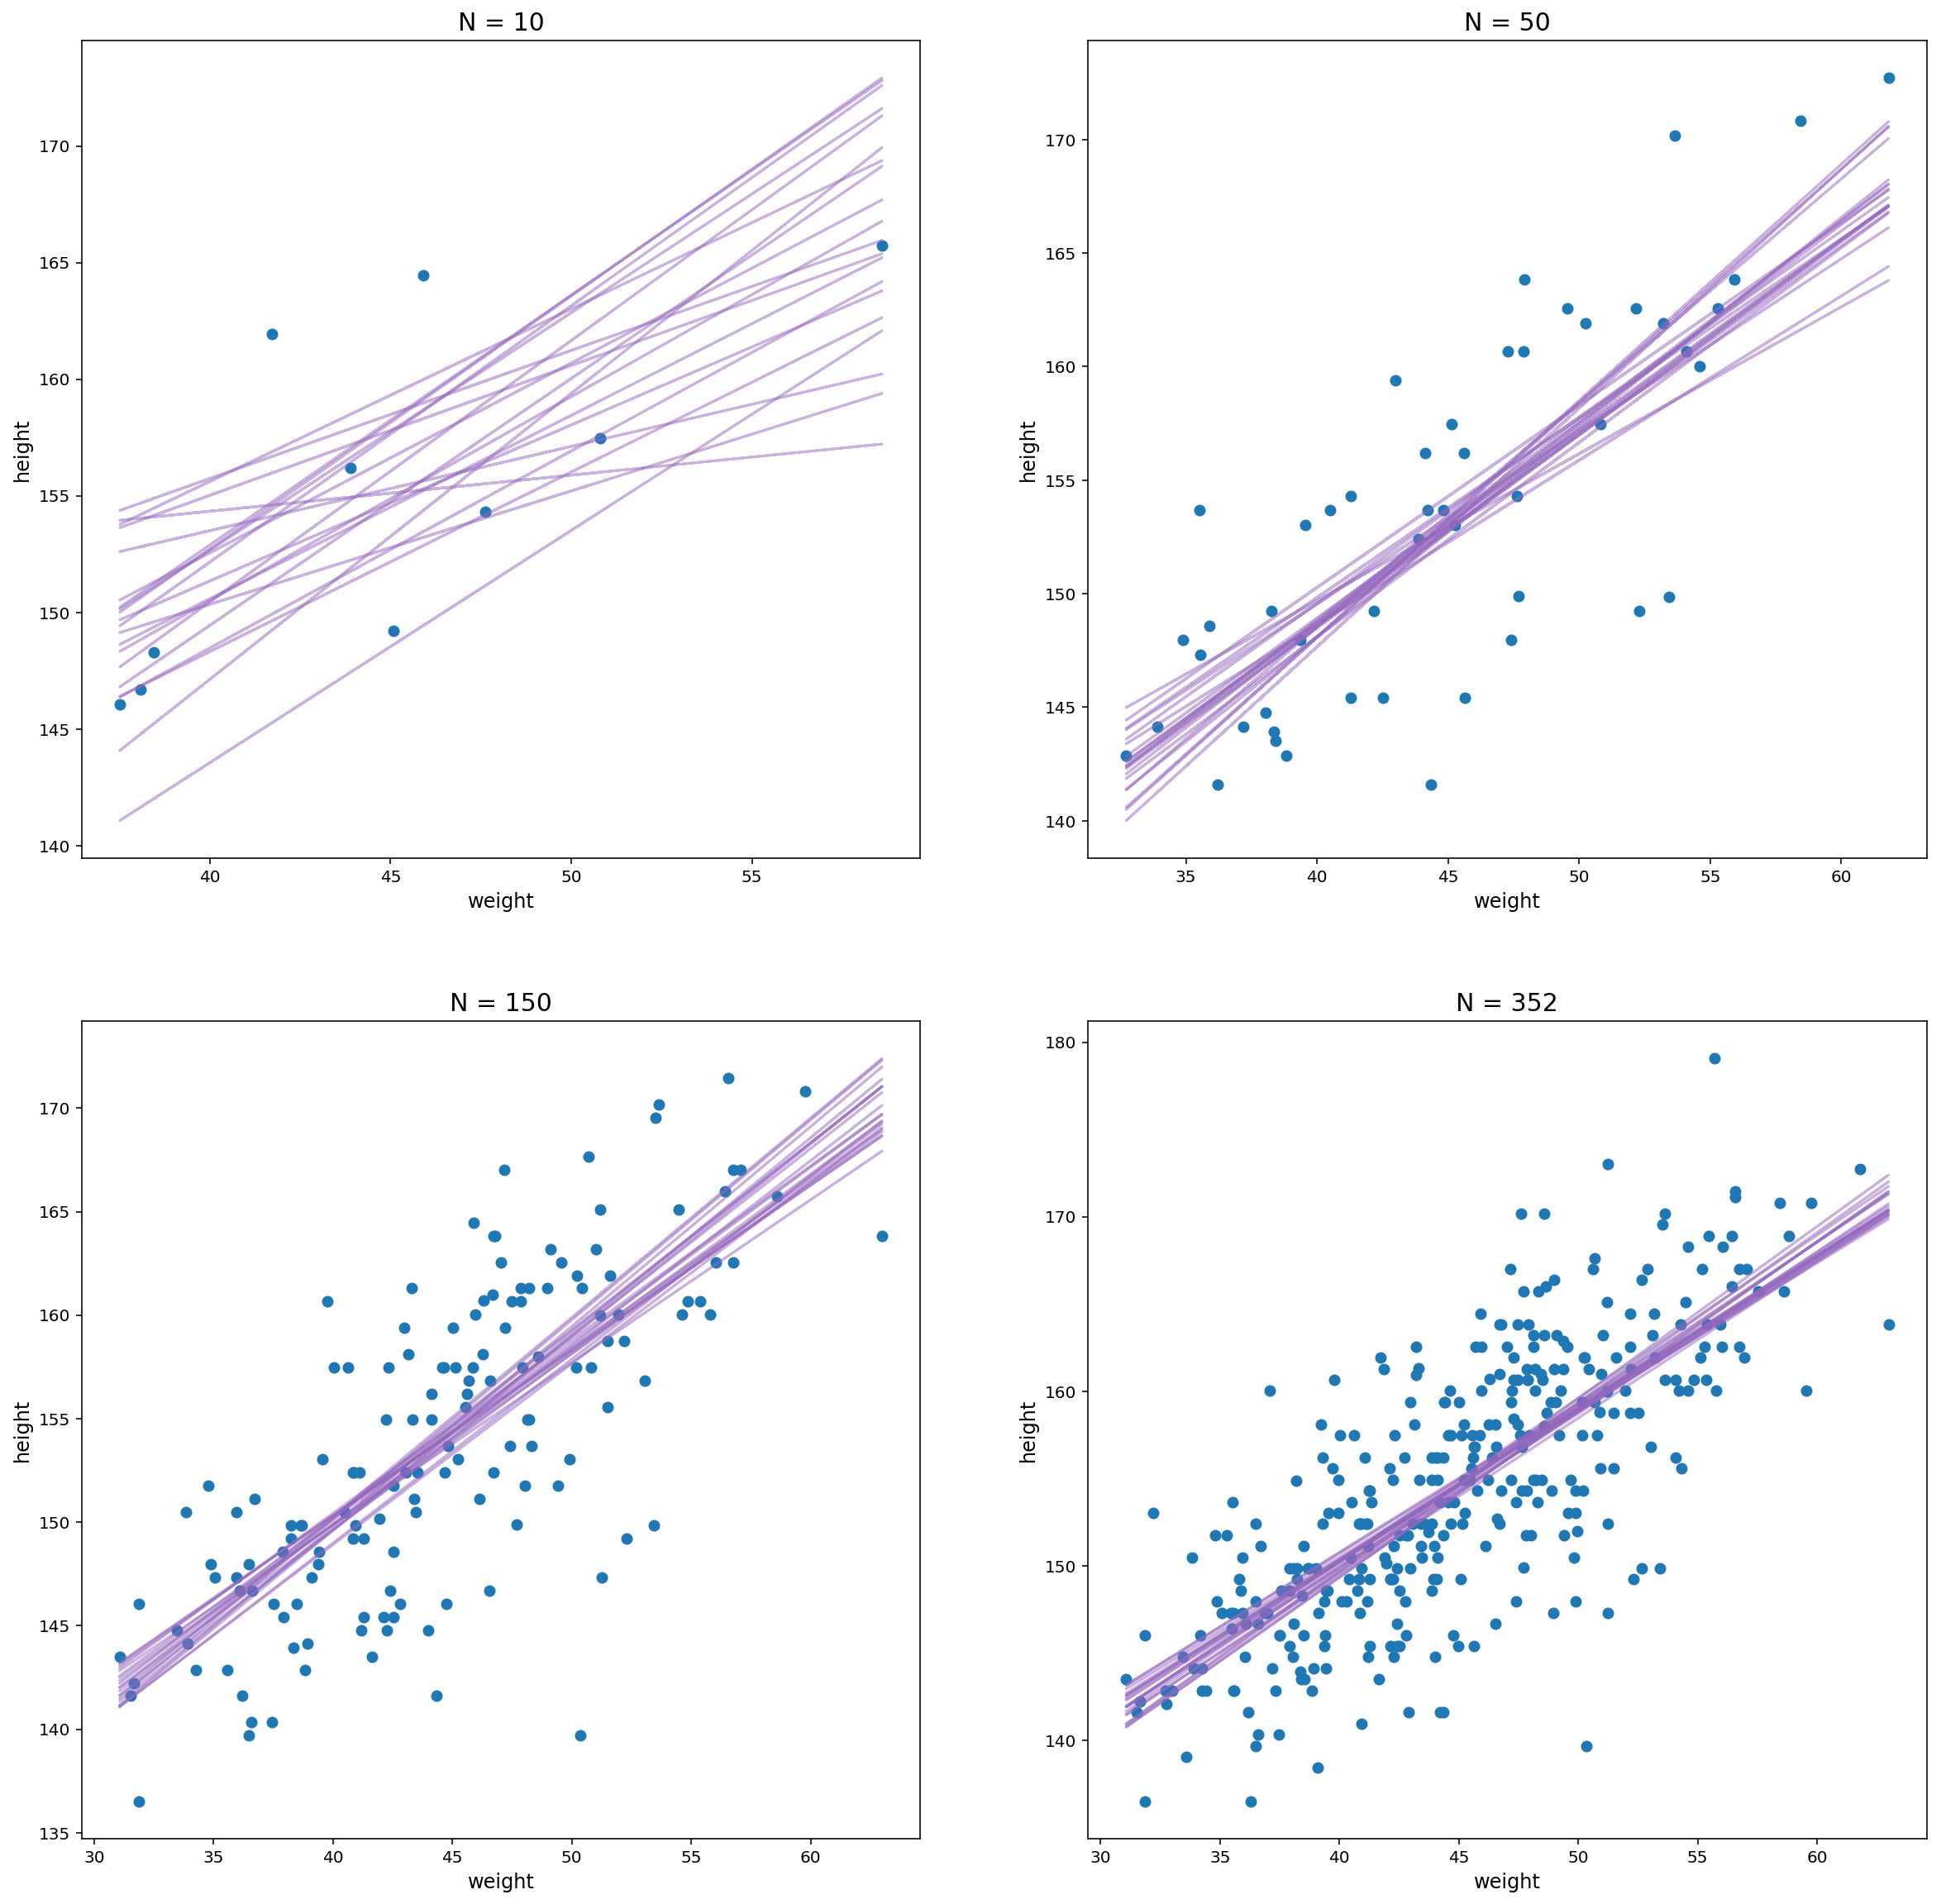

In [581]:
# 4.49
fig, axes = plt.subplots(2,2,figsize=(20,20))
axes = np.ravel(axes)
np.random.seed(125)
for idx in range(len(N)):
    dN, xbar, trace_n = samples_N[idx]
    axes[idx].plot(dN.weight, dN.height, 'o')
    
    sample_jdx = np.random.randint(len(trace_n), size=20)
    for jdx in sample_jdx:
        axes[idx].plot(dN.weight, 
                       trace_n["a"][jdx] + trace_n["b"][jdx] * (dN.weight - xbar),
                       'C4-', alpha=0.5
                      )
    axes[idx].set_title(f"N = {N[idx]}", fontsize=15)
    axes[idx].set_xlabel("weight")
    axes[idx].set_ylabel("height")

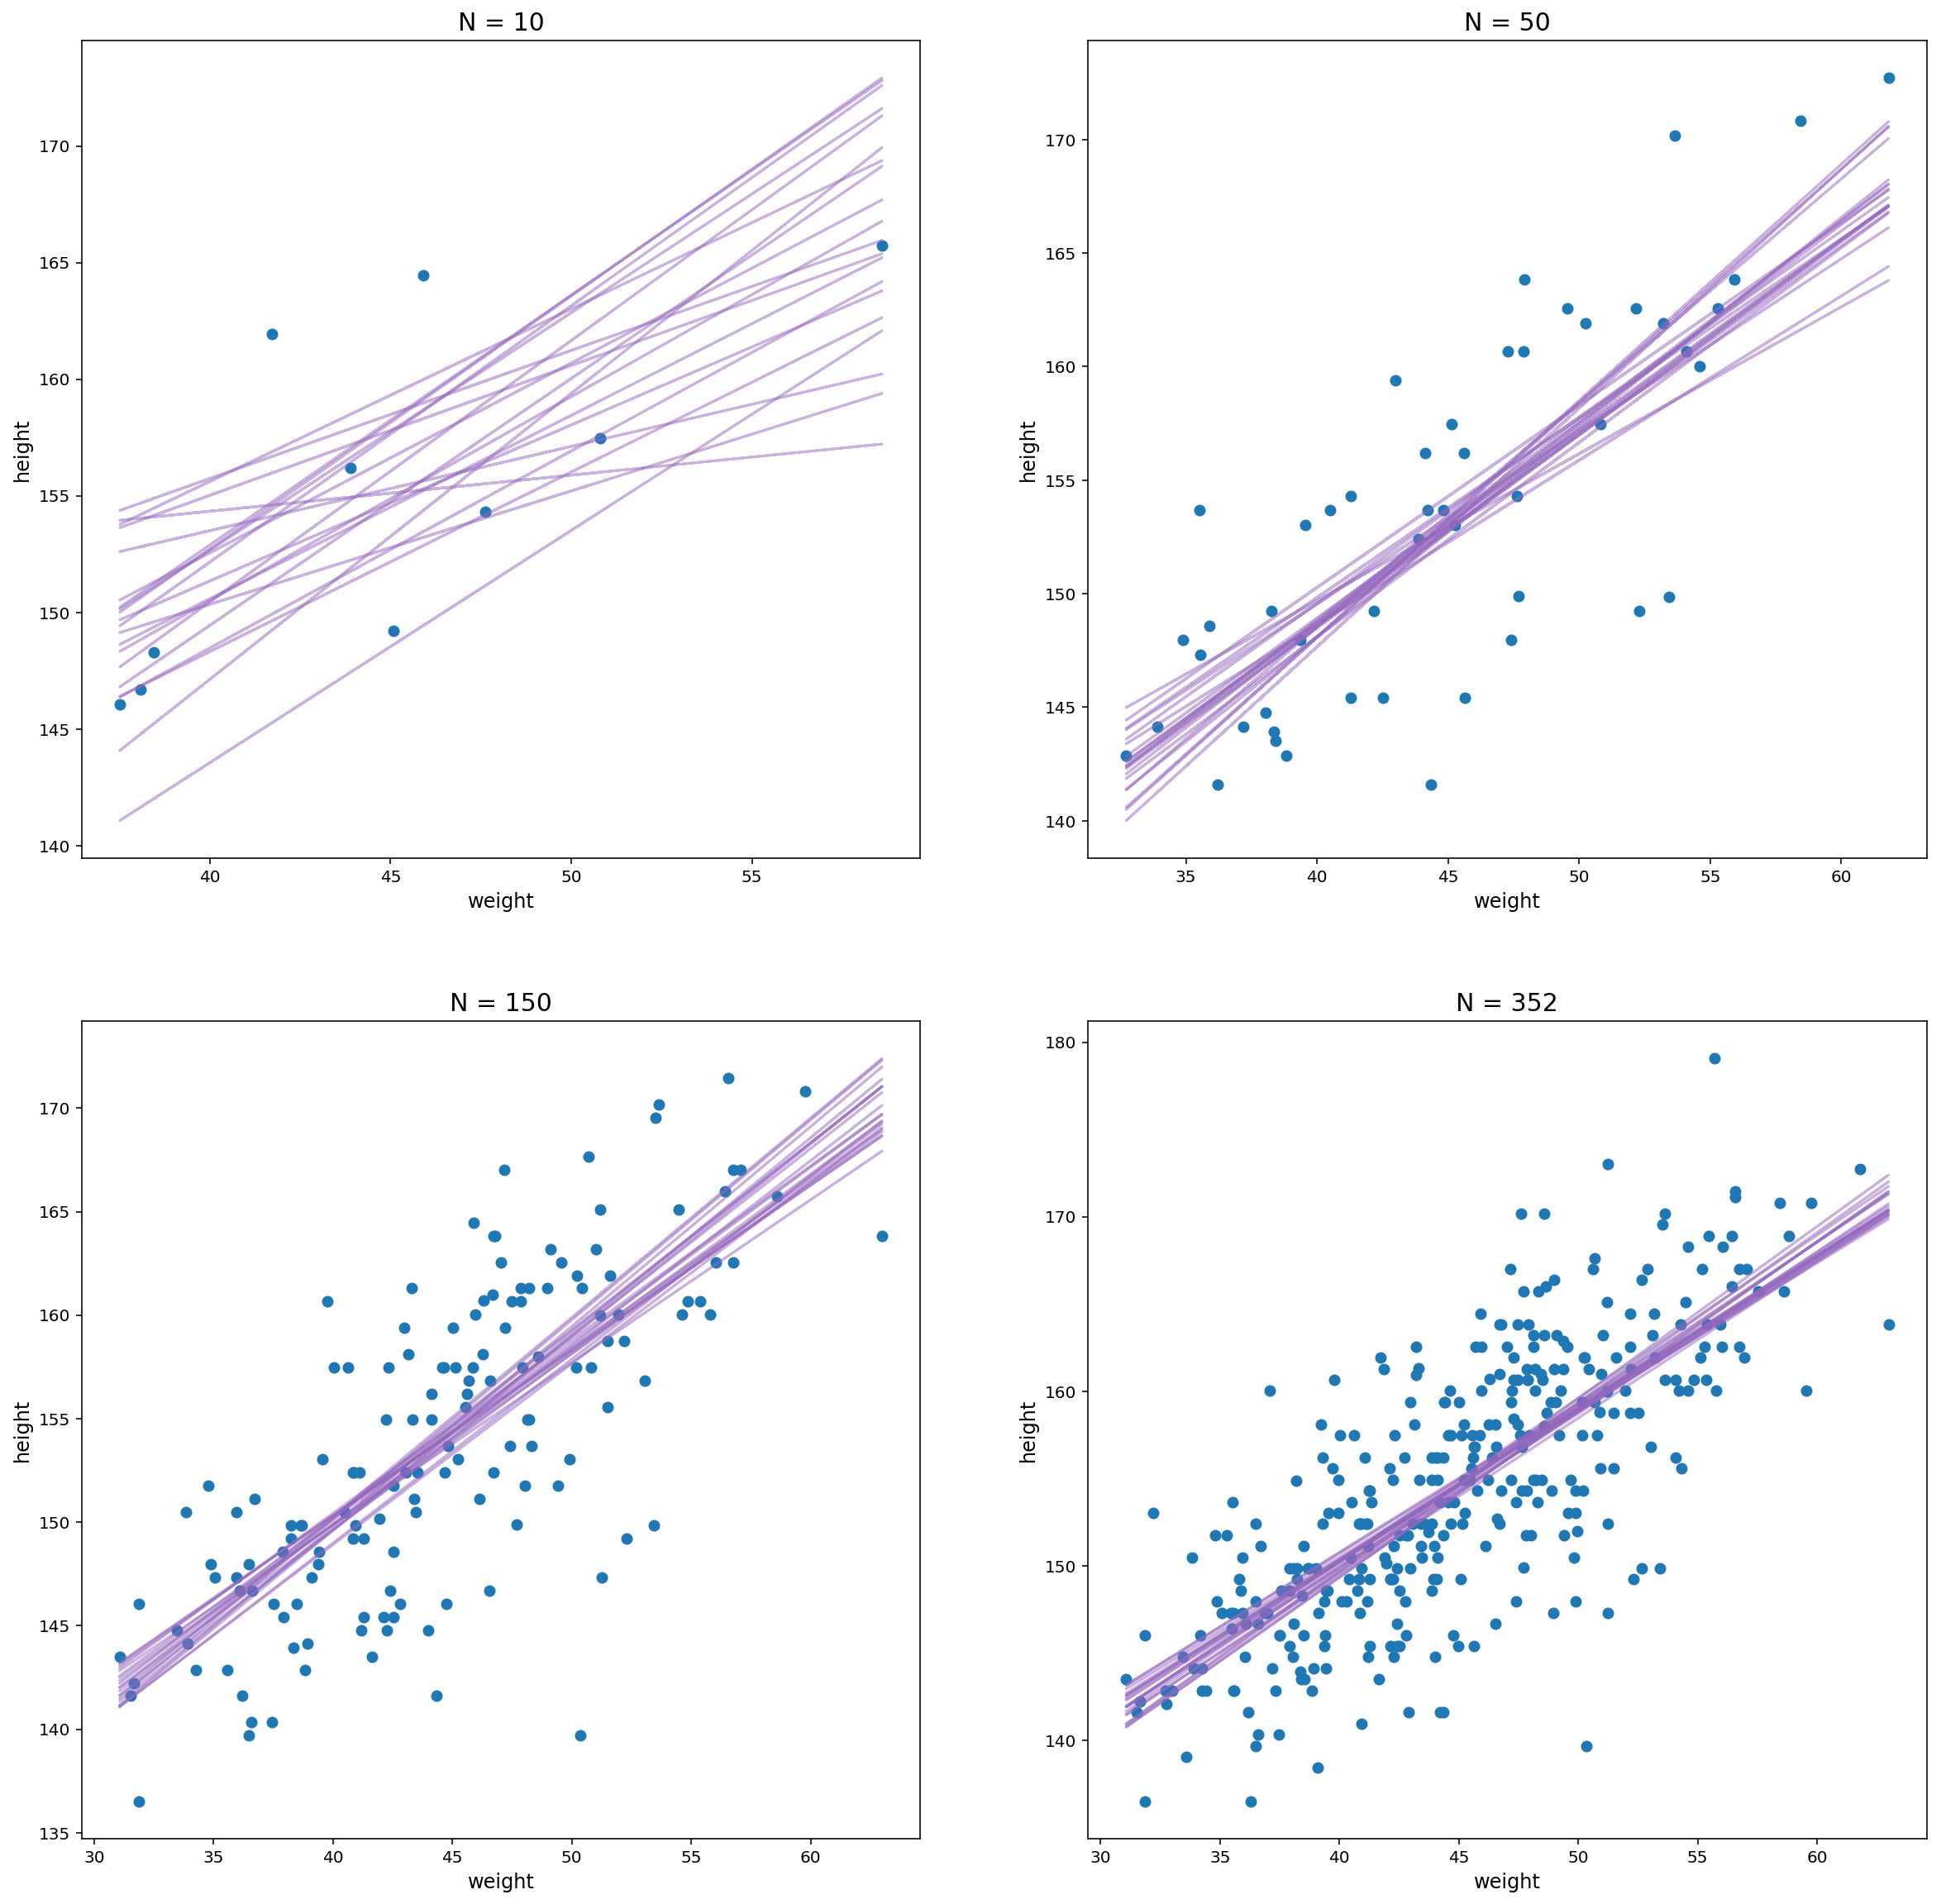

In [582]:
# Or use 'mu' from trace directly
fig, axes = plt.subplots(2,2,figsize=(20,20))
axes = np.ravel(axes)
np.random.seed(125)

for idx in range(len(N)):
    dN, xbar, trace_n = samples_N[idx]
    axes[idx].plot(dN.weight, dN.height, 'o')
    
    sample_jdx = np.random.randint(len(trace_n), size=20)
    for jdx in sample_jdx:
        axes[idx].plot(dN.weight, 
                       trace_n["mu"][jdx],
                       'C4-', alpha=0.5
                      )
    axes[idx].set_title(f"N = {N[idx]}", fontsize=15)
    axes[idx].set_xlabel("weight")
    axes[idx].set_ylabel("height")

##### 4.4.3.4. Plotting regression intervals and contours

In [583]:
# 4.50
mu_at_50 = trace_4_3['a'] + trace_4_3['b'] * (50 - d2.weight.mean())

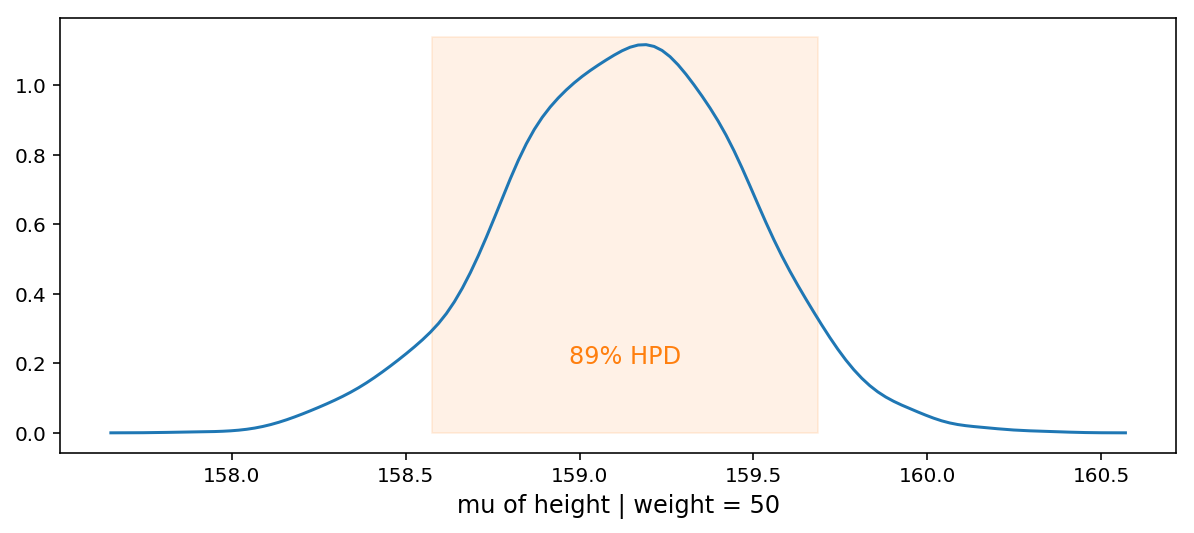

In [640]:
# 4.51
# plot the relative plausibility of different values of the mean at weight=50
sns.kdeplot(mu_at_50)
plt.xlabel("mu of height | weight = 50")
#plt.axvline(x=az.hpd(mu_at_50)[0], color='C1', linestyle="--")
#plt.axvline(x=az.hpd(mu_at_50)[1], color='C1', linestyle="--")
plt.text(x=az.hpd(mu_at_50).sum()/2, y=0.2, 
         horizontalalignment='center', s='89% HPD',
        fontsize=12, color='C1')
plt.fill_betweenx(y=np.array(plt.ylim())*0.97, x1=az.hpd(mu_at_50)[0], x2=az.hpd(mu_at_50)[1], 
                 alpha=0.1, color='C1')
pass

In [641]:
# 4.52
az.hpd(mu_at_50)

array([158.57462214, 159.685083  ])

In [647]:
# 4.53
trace_n['mu'].mean(axis=0)[:10]

array([153.45306396, 151.14777145, 144.53926626, 145.99928485,
       162.8023058 , 157.24398942, 156.14257189, 147.89474758,
       152.26499834, 154.2214948 ])

In [677]:
# 4.54
xbar = d2.weight.mean()
weight_seq = np.arange(25, 71).reshape(1, -1)
mu = trace_4_3["a"].reshape(-1,1) + trace_4_3["b"].reshape(-1,1) * (weight_seq - xbar)
mu.shape

(4000, 46)

In [676]:
# check np broadcast is correct
assert all(trace_4_3["a"] + trace_4_3["b"] * (weight_seq[0,1] - xbar) == mu[:, 1])

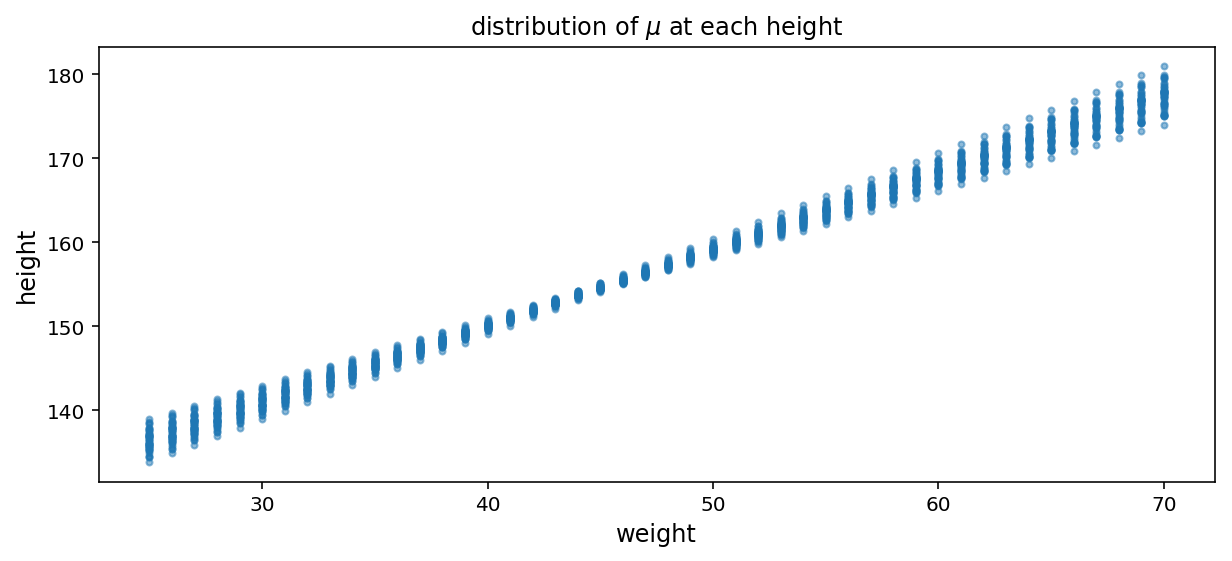

In [698]:
# 4.55
# create coordinate layout
plt.plot(d2.weight, d2.height, "o", alpha=0)

# plot the distrbution of u values at each height
for idx in range(50):
    plt.plot(weight_seq.reshape(-1), mu[idx], 'C0.', alpha=0.5)

plt.title(r"distribution of $\mu$ at each height")
plt.xlabel("weight")
plt.ylabel("height")
pass

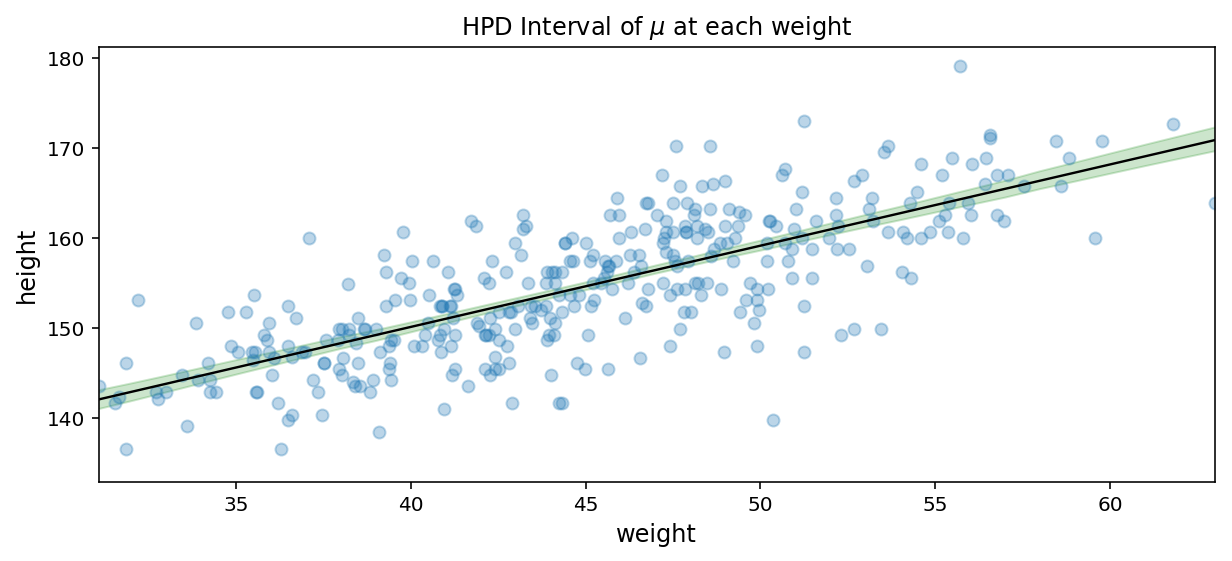

In [732]:
# 4.56 & 4.57
mu_mean = np.mean(mu, axis=0)
mu_hpd = az.hpd(mu)

plt.plot(d2.weight, d2.height, 'o', alpha=0.3)
plt.plot(weight_seq.reshape(-1), mu_mean, color='k', linewidth=1.2)
plt.fill_between(weight_seq.reshape(-1), mu_hpd[:,0], mu_hpd[:,1], 
               color='g', alpha=0.2)
plt.title(r"HPD Interval of $\mu$ at each weight")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max())
pass

##### 4.4.3.5. Prediction Intervals

For any value of weight, not restricting to the input values

In [744]:
# 4.59
sim_height = stats.norm.rvs(
    loc=mu, 
    scale=np.repeat(trace_4_3['sigma'].reshape(-1, 1), 
                    len(weight_seq), axis=1))

In [749]:
# 4.60
height_PI = az.hpd(sim_height)

(31.071052, 62.992589)

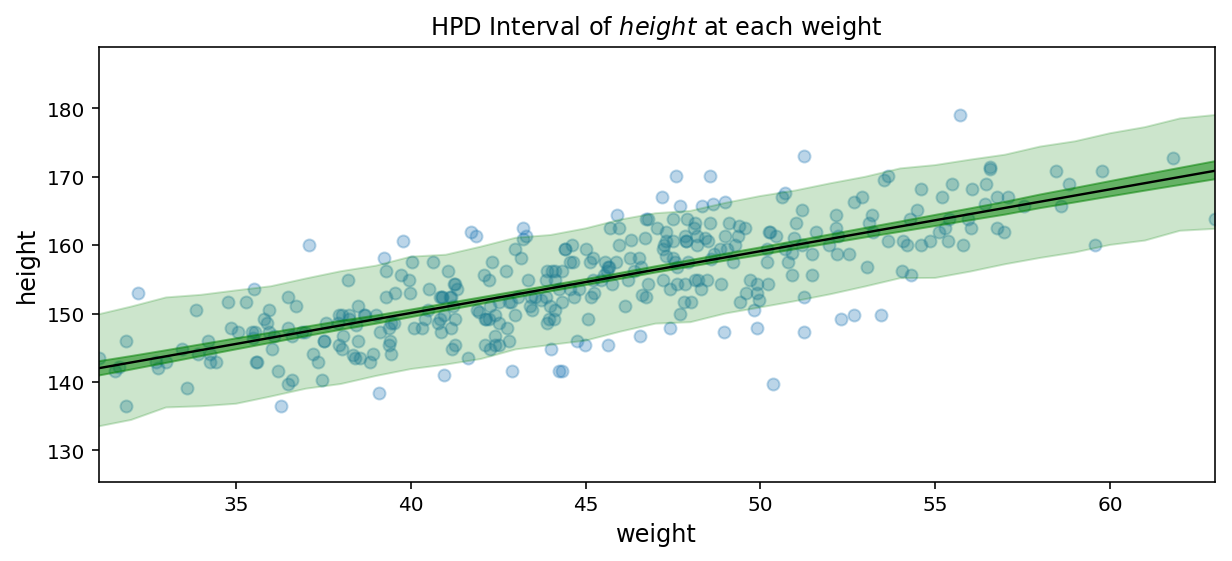

In [760]:
# 4.61
plt.scatter(d2.weight, d2.height, alpha=0.3)
plt.plot(weight_seq.flatten(), mu_mean, 'k', linewidth=1.2)
plt.fill_between(weight_seq.flatten(), mu_hpd[:,0], mu_hpd[:,1], 
               color='g', alpha=0.5)
plt.fill_between(weight_seq.flatten(), height_PI[:,0], height_PI[:,1], 
               color='g', alpha=0.2)
plt.title(r"HPD Interval of $height$ at each weight")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max())

If we only want to generate height (posterior predictive samples) for each value of the input weight, we can use `sample_posterior_predictive()` directly. 

In [761]:
height_pred = pm.sample_posterior_predictive(trace=trace_4_3, 
                                             samples=200,
                                             model=m4_3)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:02<00:00, 90.92it/s]


In [768]:
height_pred['height'].shape

(200, 352)

In [762]:
height_pred_hpd = az.hpd(height_pred["height"])

#### 4.5. Curves from lines

#### 4.5.1. Polynomial regression

In [769]:
# 4.64
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

In [773]:
# 4.65
d = d.assign(
    weight_std = (d.weight - d.weight.mean())/d.weight.std(),
    weight_std2 = lambda df: df.weight_std**2)

with pm.Model() as m4_5:
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d.weight_std + b2 * d.weight_std2)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2701.00draws/s]


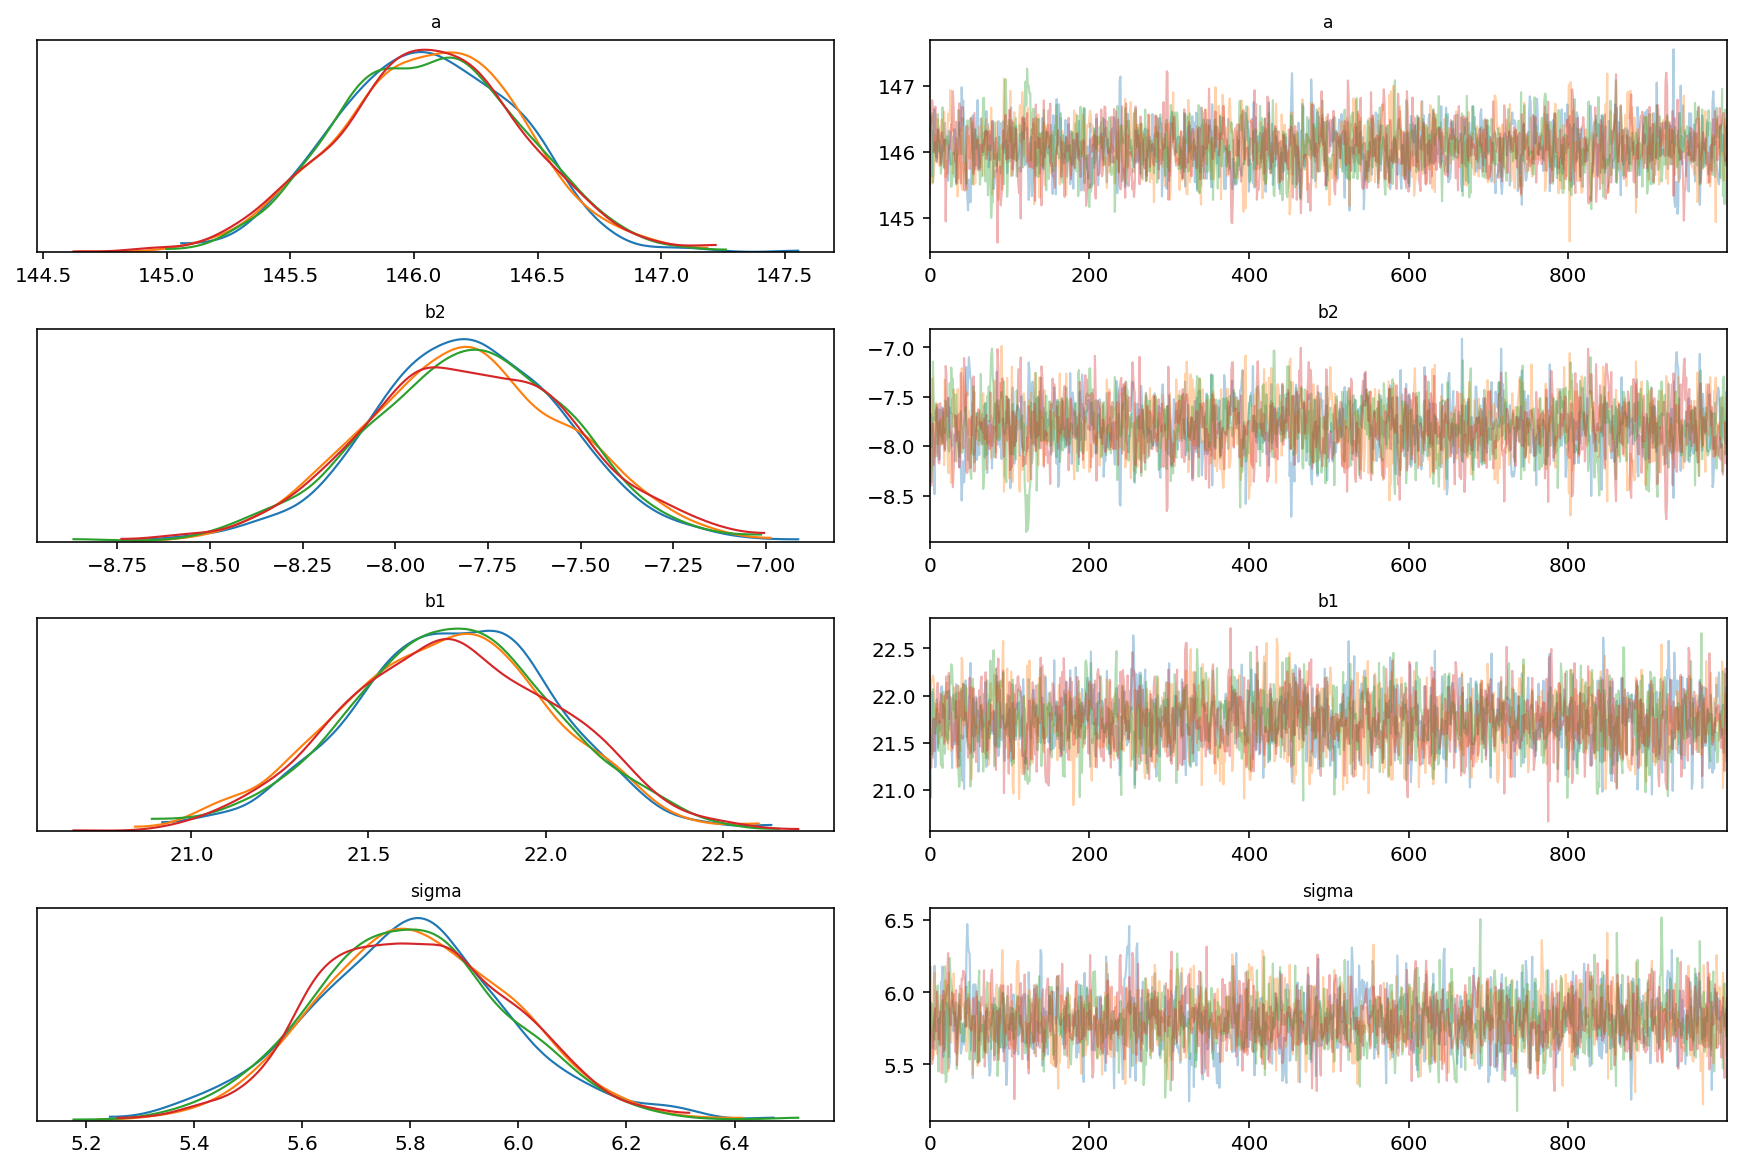

In [777]:
varnames=["~mu"]
az.plot_trace(trace_4_5, varnames)
pass

In [775]:
# 4.66
az.summary(trace_4_5, var_names=varnames, round_to=2, kind="stats")

mean    sd  hpd_5.5%  hpd_94.5%
a      146.06  0.37    145.46     146.61
b2      -7.80  0.27     -8.22      -7.34
b1      21.73  0.30     21.25      22.20
sigma    5.80  0.18      5.51       6.08

For any weight value

In [783]:
trace_4_5["mu"].shap

(4000, 544)

In [801]:
# 4.67
# input sequence
weight_seq = np.linspace(-2.2, 2, num=30)

# reconstruct mu with sampled para estimates from posterior
mu = (trace_4_5["a"] \
    + trace_4_5["b1"] * weight_seq.reshape(-1,1) \
    + trace_4_5["b2"] * (weight_seq**2).reshape(-1,1)).T

# generate height given mu and sampled sigma from posterior
sim_height = stats.norm.rvs(
    loc=mu,
    scale=np.repeat(trace_4_5['sigma'].reshape(-1, 1), 
                    len(weight_seq), axis=1))

# hpd
mu_hpd = az.hpd(mu)
height_hpd = az.hpd(sim_height)

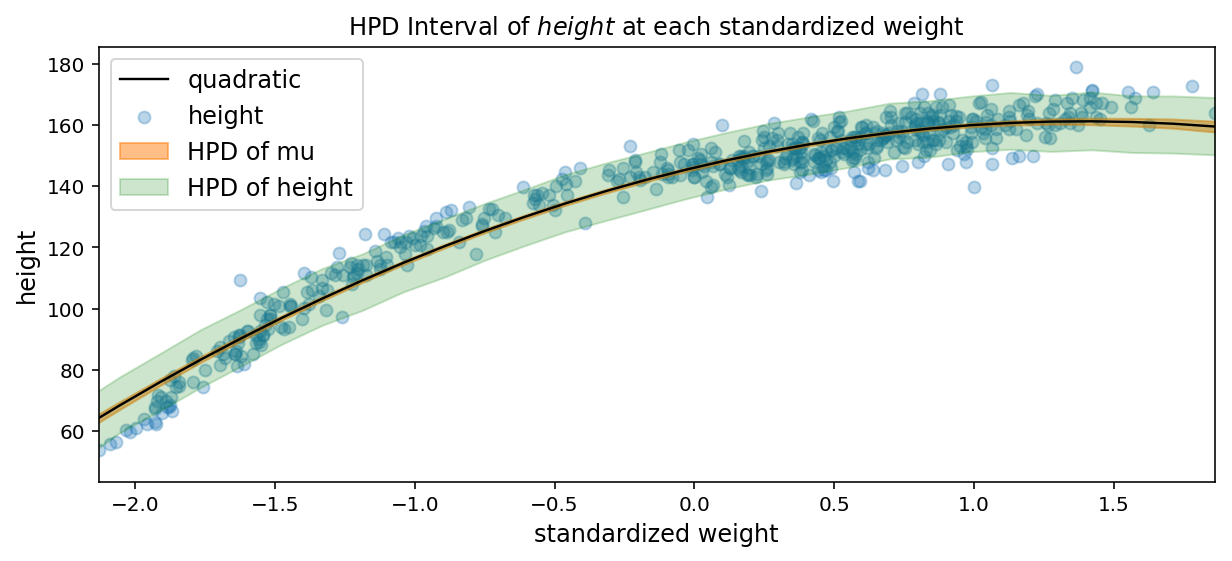

In [808]:
# 4.68
plt.scatter(d.weight_std, d.height, alpha=0.3)
plt.plot(weight_seq, mu.mean(axis=0), 'k', linewidth=1.2, label='quadratic')
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], 
               color='C1', alpha=0.5, label='HPD of mu')
plt.fill_between(weight_seq, height_hpd[:,0], height_hpd[:,1], 
               color='g', alpha=0.2, label='HPD of height')
plt.title(r"HPD Interval of $height$ at each standardized weight")
plt.xlabel("standardized weight")
plt.ylabel("height")
plt.legend(loc=0)
plt.xlim(d.weight_std.min(), d.weight_std.max())
pass

For each input value in dataset

In [809]:
mu_pred = trace_4_5["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, m4_5)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 711.99it/s]


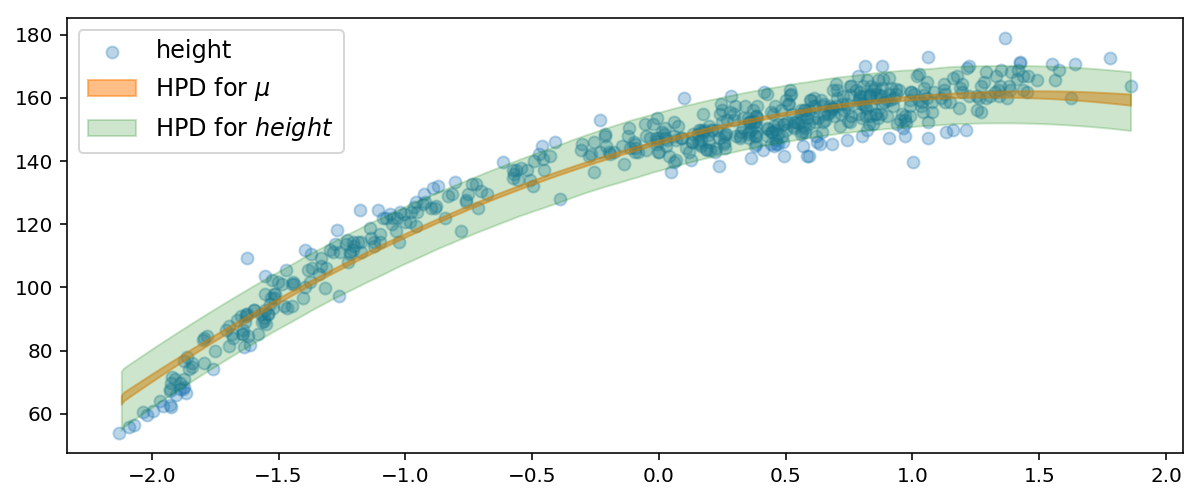

In [836]:
plt.scatter(d.weight_std, d.height, alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, color='C1', 
            fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(d.weight_std, height_pred["height"], color='g', 
            fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
plt.legend()

In [842]:
# 4.69
# create a weight matrix, in model spec,
# use dot product of beta and weight matrix
weight_m = np.vstack((d.weight_std, d.weight_std ** 2, d.weight_std ** 3))

In [844]:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1889.19draws/s]


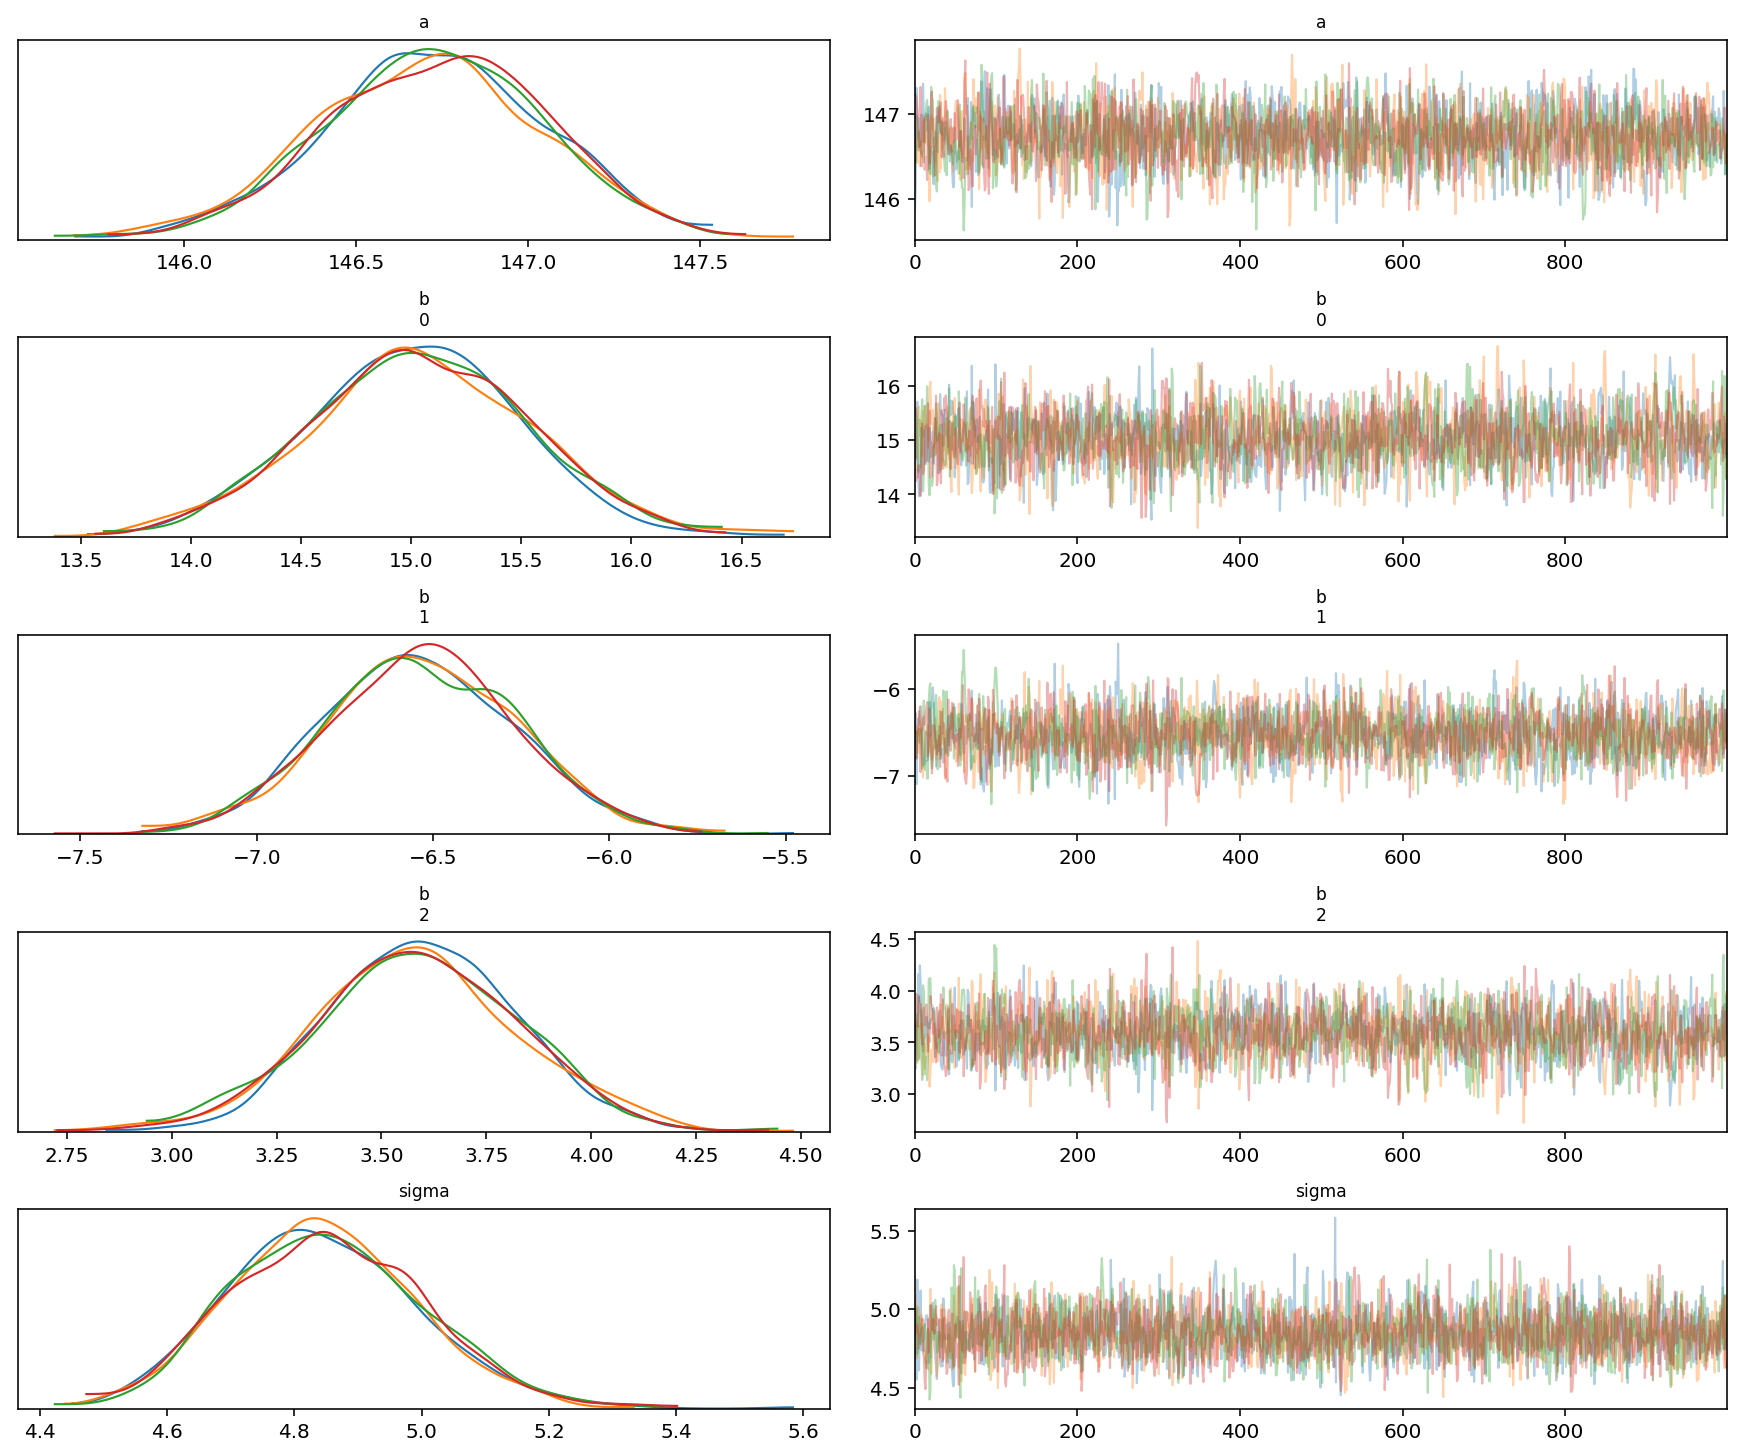

In [846]:
az.plot_trace(trace_4_6, varnames)
pass

In [857]:
height_pred['height'].shape

(200, 544)

In [859]:
# 4.70 & 4.71
mu_pred = trace_4_6["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, m_4_6)

100%|██████████| 200/200 [00:00<00:00, 931.79it/s]


Model is fitted with standardized weight. Plot on original unscaled weight against height. Here I use 'weight' column directly.

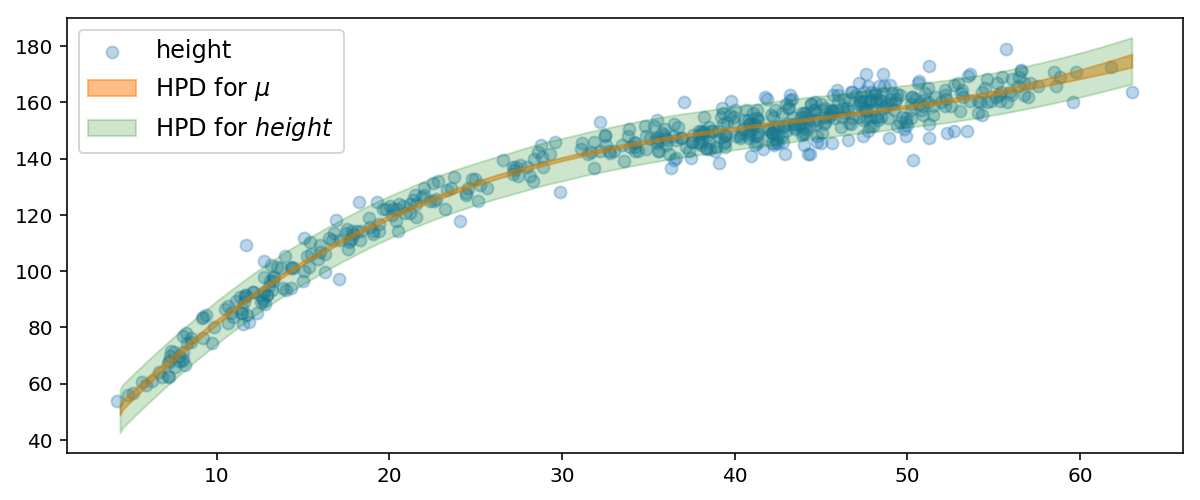

In [869]:
plt.scatter(d.weight, d.height, alpha=0.3)
az.plot_hpd(d.weight, mu_pred, color='C1',
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(d.weight, height_pred["height"], color='g',
           fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
plt.legend()
pass

Both the book and pymc dev codes use the standardized_weight to make the plot and then replace the xtick_labels with the unscaled weights. But WHY? Isn't this the same as directly using the original weight column? The plots look exactly the same. I am confused....

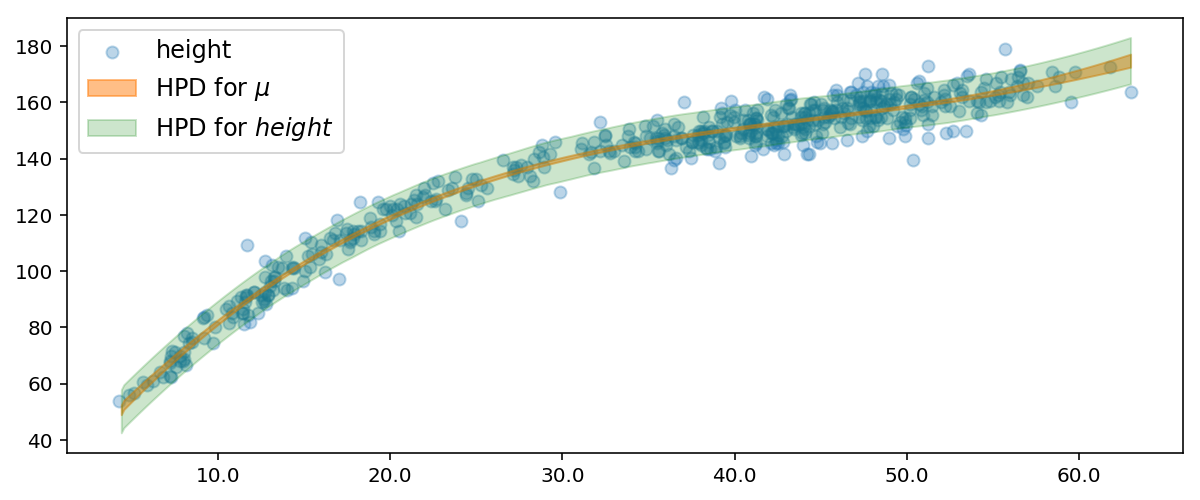

In [879]:
plt.scatter(d.weight_std, d.height, alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred,
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(d.weight_std, height_pred["height"], color='g',
           fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
plt.legend()
at = (np.arange(10, 61, 10) - d.weight.mean())/ d.weight.std()
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(),1));

#### 4.5.2. Splines

In [881]:
# 4.72
d = pd.read_csv("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data/cherry_blossoms.csv")
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hpd_5.5%  hpd_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

In [945]:
# 4.73
d2 = d.dropna(subset=["doy"])
num_knots = 5 #15
knot_list = np.quantile(d2.year, q=np.linspace(0,1,num=num_knots))

In [946]:
# 4.74
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

In [947]:
B.shape

(827, 7)

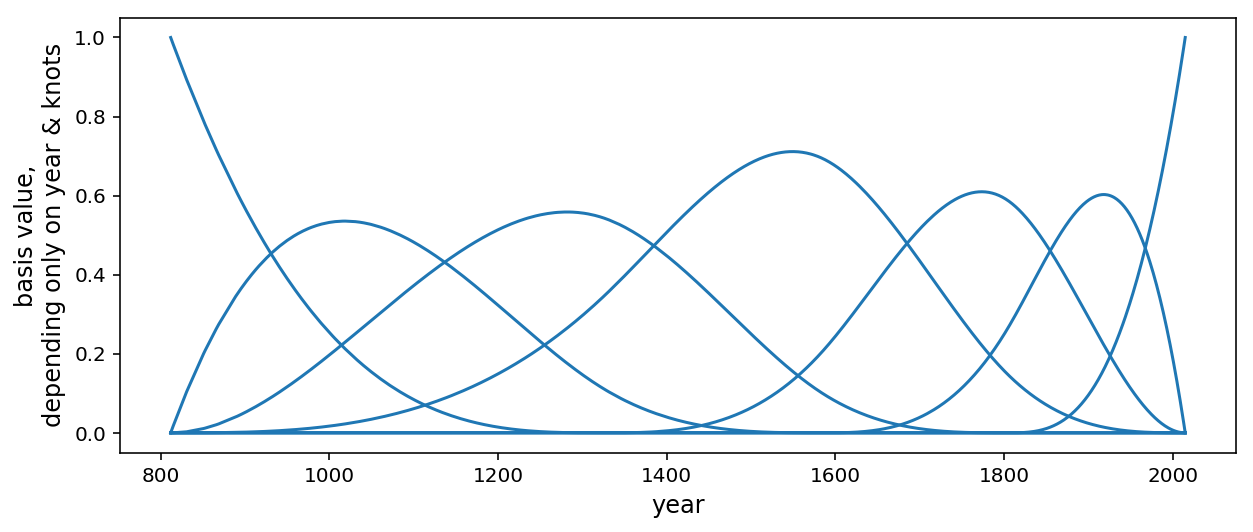

In [948]:
# 4.75
_, ax1 = plt.subplots(1, 1)
for i in range(B.shape[1]):
    ax1.plot(d2.year, B[:,i], color='C0')
ax1.set_xlabel('year')
ax1.set_ylabel('basis value,\ndepending only on year & knots')
pass

In [949]:
# 4.76
with pm.Model() as m4_7:
    a = pm.Normal("a", mu=100, sigma=10)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    sigma = pm.Exponential("sigma", lam=1)
    mu = pm.Deterministic("mu", 
                          a + pm.math.dot(
                              np.asarray(B, order='F'),
                              w)
                         )
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d2.doy)
    trace4_7 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]





Sampling 4 chains, 0 divergences:   0%|          | 0/6000 [00:00<?, ?draws/s]




Sampling 4 chains, 0 divergences:   1%|▏         | 82/6000 [00:00<00:07, 791.76draws/s]




Sampling 4 chains, 0 divergences:   2%|▏         | 106/6000 [00:00<00:20, 281.41draws/s]




Sampling 4 chains, 0 divergences:   2%|▏         | 126/6000 [00:00<00:33, 173.58draws/s]




Sampling 4 chains, 0 divergences:   2%|▏         | 143/6000 [00:00<00:41, 140.66draws/s]




Sampling 4 chains, 0 divergences:   3%|▎         | 158/6000 [00:00<00:43, 133.83draws/s]




Sampling 4 chains, 0 divergences:   3%|▎         | 172/6000 [00:00<00:50, 115.05draws/s]




Sampling 4 chains, 0 divergences:   3%|▎         | 186/6000 [00:01<00:49, 117

In [950]:
az.summary(trace4_7, varnames)

mean     sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
a      102.631  3.565    97.390    108.950      0.151    0.108     554.0   
w[0]    -4.715  4.092   -10.828      2.169      0.158    0.112     673.0   
w[1]     5.658  4.130    -0.961     12.325      0.150    0.106     758.0   
w[2]     0.502  3.910    -5.710      6.553      0.156    0.111     626.0   
w[3]     2.566  3.725    -3.424      8.577      0.153    0.108     595.0   
w[4]     4.613  3.739    -1.193     10.677      0.151    0.107     614.0   
w[5]     2.287  3.822    -3.894      8.181      0.154    0.109     618.0   
w[6]    -8.147  3.752   -14.540     -2.579      0.152    0.111     613.0   
sigma    6.026  0.151     5.769      6.246      0.003    0.002    2098.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a       549.0     558.0     818.0    1.0  
w[0]    669.0     676.0    1058.0    1.0  
w[1]    758.0     757.0    1114.0    1.0  
w[2]    626.0     630.0    1098.0    1.0  
w[3]    595.0     596.0     815.0    1.0  
w[4]    614.0     619.0     911.0    1.0  
w[5]    618.0     618.0     937.0    1.0  
w[6]    574.0     617.0     998.0    1.0  
sigma  2098.0    2095.0    1856.0    1.0

In [953]:

B.shape

(827, 7)

In [954]:
trace4_7["w"].shape

(4000, 7)

In [959]:
np.dot(B.base, w_mean).shape

(827,)

(-6, 4)

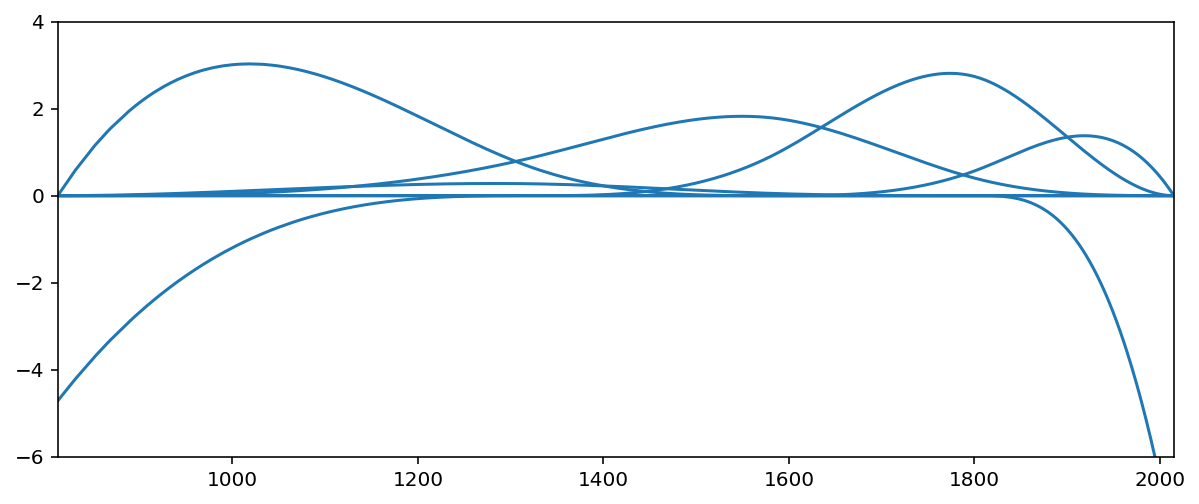

In [966]:
# 4.77
w_mean = trace4_7["w"].mean(axis=0)
for i in range(len(w_mean)):
    plt.plot(d2.year, B[:,i] * w_mean[i], color='C0')
plt.xlim(812, 2015)
plt.ylim(-6, 4)

Text(0, 0.5, 'Day in Year')

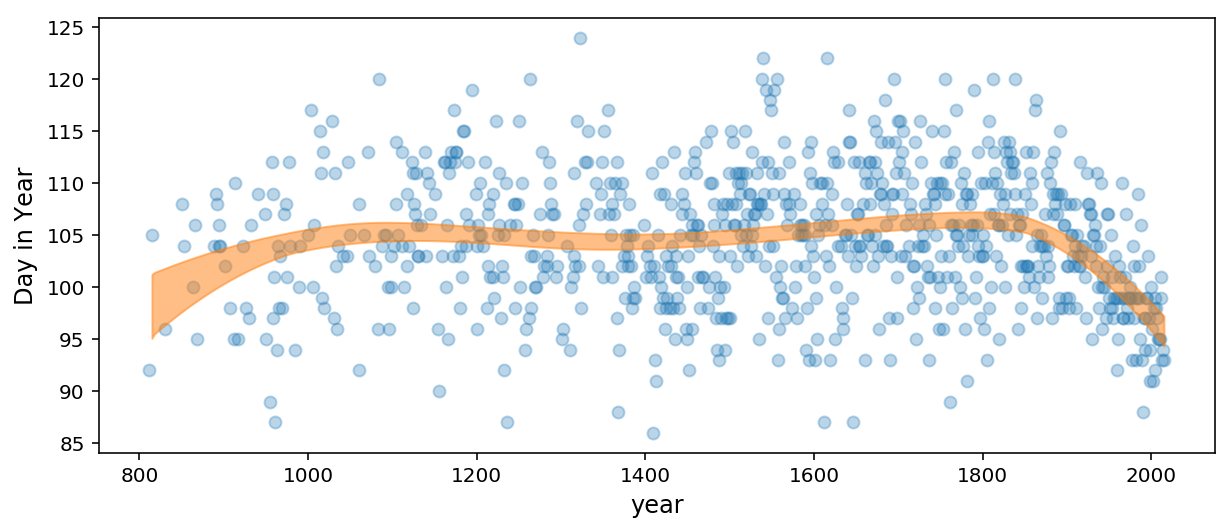

In [974]:
# 4.78
mu = trace4_7["mu"]
mu_PI = az.hpd(mu)

# plt.plot
plt.scatter(d2.year, d2.doy, alpha=0.3)
az.plot_hpd(d2.year, mu)
plt.xlabel("year")
plt.ylabel("Day in Year")

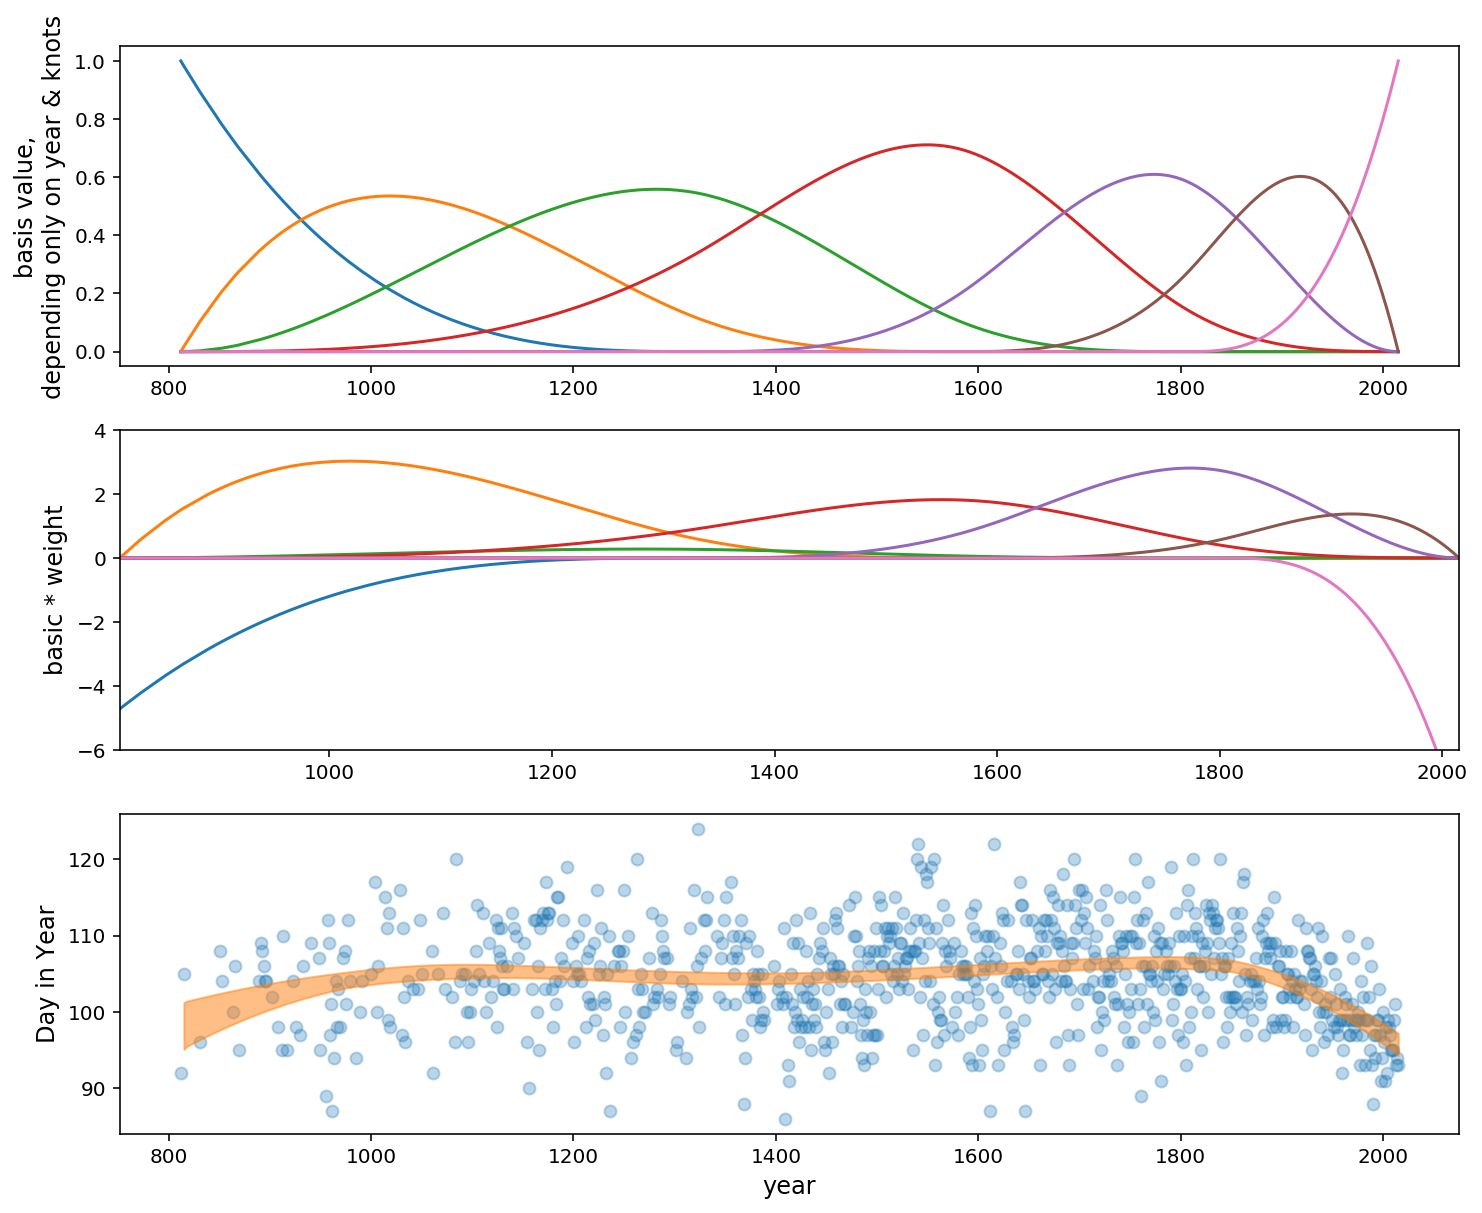

In [995]:
# Bring three plots into one
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,10))

# Just basic function values -> B-Splines
for i in range(B.shape[1]):
    ax1.plot(d2.year, B[:,i])
ax1.set_ylabel('basis value,\ndepending only on year & knots')

# basic values * fitted posterior weights -> Weighted B-Splines
w_mean = trace4_7["w"].mean(axis=0)
for i in range(len(w_mean)):
    ax2.plot(d2.year, B[:,i] * w_mean[i])
ax2.set_xlim(812, 2015)
ax2.set_ylim(-6, 4)
ax2.set_ylabel("basic * weight")

# HPD of mu = alpha + sum of all weighted splines at each year
mu = trace4_7["mu"]
mu_PI = az.hpd(mu)
ax3.scatter(d2.year, d2.doy, alpha=0.3)
az.plot_hpd(d2.year, mu, ax=ax3)
ax3.set_xlabel("year")
ax3.set_ylabel("Day in Year")
pass

In [996]:
%watermark -n -u -v -iv -w

seaborn   0.10.1
pymc3     3.8
arviz     0.7.0
watermark 2.0.2
numpy     1.18.1
pandas    1.0.3
last updated: Tue May 26 2020 

CPython 3.7.6
IPython 7.14.0
watermark 2.0.2
